In [1]:
! pip install lightgbm

In [291]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import cross_validate, train_test_split, cross_val_score
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, explained_variance_score, accuracy_score, roc_auc_score
from sklearn import metrics
import time
import math
import lightgbm as lgb
from sklearn.neural_network import MLPRegressor, MLPClassifier

import warnings, sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)

In [3]:
os.listdir('dataset')

['.ipynb_checkpoints',
 '.~Santa Clara County, California_listings.csv',
 'Clark County, NV, Nevada_listings.csv',
 'Hawaii, Hawaii_listings.csv',
 'Jersey City, New Jersey_listings.csv',
 'New York City, New York_listings.csv',
 'San Francisco, California_listings.csv',
 'Santa Clara County, California_listings.csv']

In [4]:
# Top 3

NY = pd.read_csv('dataset/New York City, New York_listings.csv')
SF = pd.read_csv('dataset/San Francisco, California_listings.csv')
JC = pd.read_csv('dataset/Jersey City, New Jersey_listings.csv')

# Bottom 3

HI = pd.read_csv('dataset/Hawaii, Hawaii_listings.csv')
SCC = pd.read_csv('dataset/Santa Clara County, California_listings.csv')
CC = pd.read_csv('dataset/Clark County, NV, Nevada_listings.csv')

# 전처리 함수

In [5]:
def list_count(string):
    return len(string.split(','))

def split_first(string):
    if type(string)==float:
        return np.nan
    
    else:
        return float(string.split(' ')[0])

    
    

def preprocess(df):
    
    # 1. remove unnecessary columns
    
    df = df.drop(['listing_url', 'scrape_id', 'name', 'host_id', 'description', 'picture_url', 
                  'host_thumbnail_url', 'neighborhood_overview', 'host_url', 'host_name', 'host_location', 'host_about', 
                  'host_picture_url', 'host_total_listings_count', 'neighbourhood', 'host_verifications', 'property_type',
                 'minimum_minimum_nights', 'minimum_maximum_nights', 'maximum_minimum_nights', 'maximum_maximum_nights',
                 'has_availability', 'calendar_last_scraped', 'first_review', 'last_review',
                 'host_listings_count', 'number_of_reviews', 'number_of_reviews_l30d', 'host_response_rate', 
                  'host_acceptance_rate', 'host_neighbourhood', 'calculated_host_listings_count_entire_homes',
                  'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',
                 'neighbourhood_group_cleansed', 'neighbourhood_cleansed', 'license'], axis=1)
    
    # host_name은 host_id로 설명 가능해서 제거, name과 host_about, url들은 마땅히 할 수 있는 것이 없어서 제거 
    # (숙소사진, 호스트사진 포함), 
    # description, neighborhood_overview에 있는 내용은 다른 컬럼들로 설명가능하기에 삭제
    # host_total_listings_count와 host_listings_count는 아래 그림에서 보이듯이(corr) calculated_host_listings_count로 대체 가능하므로 삭제
    # 또한 calculated_host_listings_count_entire_homes, calculated_host_listings_count_private_rooms, 
    # calculated_host_listings_count_shared_rooms 또한 calculated_host_listings_count로 대체 가능하므로 삭제
    # neighbourhood는 neighbourhood_cleansed로 설명가능하므로 삭제
    # host_verification은 host_identity_verified로 설명되어있으므로 삭제
    # property_type은 room_type로 설명될 수 있으므로 삭제
    # minimum_minimum_nights, minimum_maximum_nights, maximum_minimum_nights, maximum_maximum_nights는 아래 그림에서 볼 수 있듯이
    # minimum_nights_ntm, maximum_nights_ntm과 상관관계가 높게 나오므로 삭제
    # has_availability는 availability_30, availability_60, availability_90, availability_365로 설명가능할 것이므로 삭제
    # number_of_reviews랑 number_of_reviews_l30d는 number_of_reviews_ltm으로 설명가능하므로 삭제 (밑에 corr 그림 참조)
    # host_response_rate는 주관적이고, 이거랑 host_acceptance_rate는 객관적인 host_response_time으로 대체 가능하므로 삭제 (밑에 corr 그림 참조)
    # host_neighbourhood랑 host_location은 host가 숙소근처에 있는지 여부가 중요한 변수가 될 수 있으므로 포함시키는 것이 좋을 수도 있다. 
    # 하지만 host_response_time으로 대체가능할 것이므로 삭제함
    
    
    # 2. 70%이상이 null 인경우 drop 시키기 
    # (drop 시킬 떄 문제점: 뒤에 있는 전처리 과정에서 충돌이 생길 수도 있고, host_response_time과 같은 중요한 정보를 삭제할 수 있다)
    
    for col in df.columns:
        series = df[col]
        if  series.isna().sum() / df.shape[0] > 0.7:
            df = df.drop(col, axis=1)
    
    # 3. 나머지 결측값있는 행 싸그리 제거
      
    df = df.dropna(axis=0).reset_index(drop=True)
    
    # 4. remove $ sign
    
    df['price'] = df['price'].replace('\$', '', regex=True).replace(',', '', regex=True)
    df['price'] = df['price'].astype('float')
    
    # 5. host_since를 상관관계 분석 용도로 현재 날짜-host_since를 계산해서 일수 (자연수)로 만드는 전처리 
    
    latest = pd.to_datetime(df['last_scraped'], format = '%Y-%m-%d')
    since = pd.to_datetime(df['host_since'], format = '%Y-%m-%d')

    df['host_since'] = (latest - since).dt.days
    
    df = df.drop('last_scraped', axis=1)
    
    # 6. 인코딩
    
    encoder = LabelEncoder()       
    df['host_is_superhost'] = encoder.fit_transform(df['host_is_superhost'])
    df['host_has_profile_pic'] = encoder.fit_transform(df['host_has_profile_pic'])
    df['host_identity_verified'] = encoder.fit_transform(df['host_identity_verified'])
    df['room_type'] = encoder.fit_transform(df['room_type'])
    df['instant_bookable'] = encoder.fit_transform(df['instant_bookable'])
    df['host_response_time'] = df['host_response_time'].replace({'within an hour' : 4, 'within a few hours' : 3, 'within a day' : 2, 'a few days or more': 1})
    
    # host_verification은 host의 본인인증정보이다 --> 리스트를 len으로 해서 얼마나 신뢰가능한 호스트인지 확인할 수 있도록 전처리
    #    (아마도 is_superhost와 상관관계가 높게나오지 않을까.)
    # 의문점: host_identity_verified는 뭐지? f가 나오는 값들은 어떤 특징들이 있을까?? --> 보류
    
    # 7. amenities를 개수로 바꿈
    
    df['amenities'] = df['amenities'].apply(list_count)
    
    # 8. bathrooms_text 에서 bathroom 개수만 뽑아냄
    
    searchfor = ['half', 'Half']
    
    tmp = df['bathrooms_text']
    
    for idx in tmp[tmp.str.contains('|'.join(searchfor))].index:
        df.loc[idx, 'bathrooms_text'] = '0.5'

    df['bathrooms_text'] = df['bathrooms_text'].apply(split_first)
    
    # 9. review 요소들을 합쳐서 하나로 만듦 (평균값)
    
    df['reviews'] = (df['review_scores_accuracy'] + df['review_scores_cleanliness'] + df['review_scores_checkin'] + df['review_scores_communication'] + df['review_scores_location'] + df['review_scores_value']) / 6
    df = df.drop(['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value'], axis=1)
    
    return df

In [6]:
NY_preprocessed = preprocess(NY)
NY_preprocessed

,id,host_since,host_response_time,host_is_superhost,host_has_profile_pic,host_identity_verified,latitude,longitude,room_type,accommodates,...,availability_30,availability_60,availability_90,availability_365,number_of_reviews_ltm,review_scores_rating,instant_bookable,calculated_host_listings_count,reviews_per_month,reviews
0,3831,4324,4,0,1,1,40.68514,-73.95976,0,3,...,2,2,2,2,70,89.0,0,1,4.82,8.833333
1,5136,4265,3,0,1,0,40.66120,-73.99423,0,4,...,24,54,84,359,0,97.0,0,1,0.01,9.666667
2,5178,4236,3,0,1,0,40.76489,-73.98493,2,2,...,29,53,78,350,25,84.0,0,1,3.40,8.833333
3,5552,4245,2,0,1,1,40.73552,-74.01042,0,2,...,0,5,35,125,0,97.0,0,1,0.48,9.833333
4,5803,4234,3,1,1,1,40.66829,-73.98779,2,2,...,0,0,0,0,7,94.0,0,3,1.30,10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15205,45640199,123,3,0,1,1,40.70953,-73.96352,2,2,...,5,35,65,340,2,100.0,0,1,2.00,10.000000
15206,45656925,3722,4,0,1,0,40.69944,-73.92793,2,1,...,9,39,69,69,1,100.0,0,1,1.00,10.000000
15207,45702596,664,4,0,1,1,40.75966,-73.89817,2,1,...,28,58,88,177,1,100.0,1,10,1.00,10.000000
15208,45712092,660,4,0,1,1,40.75830,-73.89812,2,2,...,23,53,83,173,1,80.0,1,10,1.00,9.666667


# outlier 제거하는 함수

In [7]:
# outlier_columns 에는 이상치가 있는 행들을 적어주어야 합니다

outlier_columns = ['price', 'reviews_per_month', 'reviews', 'calculated_host_listings_count', 'minimum_nights', 'maximum_nights']

In [8]:
def remove_outliers(df):
    for col in outlier_columns:
        top_75 = df[col].describe()['75%'] 
        top_25 = df[col].describe()['25%']
        IQR = df[col].describe()['75%'] - df[col].describe()['25%']
        df = df.loc[(df[col] >= top_25 - IQR * 1.5) & (df[col] <= top_75 + IQR * 1.5), :]
        df = df.reset_index(drop=True)
    return df

In [9]:
NY_preprocessed = remove_outliers(NY_preprocessed)
NY_preprocessed

,id,host_since,host_response_time,host_is_superhost,host_has_profile_pic,host_identity_verified,latitude,longitude,room_type,accommodates,...,availability_30,availability_60,availability_90,availability_365,number_of_reviews_ltm,review_scores_rating,instant_bookable,calculated_host_listings_count,reviews_per_month,reviews
0,5136,4265,3,0,1,0,40.66120,-73.99423,0,4,...,24,54,84,359,0,97.0,0,1,0.01,9.666667
1,5178,4236,3,0,1,0,40.76489,-73.98493,2,2,...,29,53,78,350,25,84.0,0,1,3.40,8.833333
2,5552,4245,2,0,1,1,40.73552,-74.01042,0,2,...,0,5,35,125,0,97.0,0,1,0.48,9.833333
3,5803,4234,3,1,1,1,40.66829,-73.98779,2,2,...,0,0,0,0,7,94.0,0,3,1.30,10.000000
4,7097,4161,4,1,1,1,40.69121,-73.97277,0,4,...,19,47,56,331,23,97.0,1,2,1.78,9.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9403,45634265,2446,4,0,1,1,40.68884,-73.99550,0,3,...,11,26,56,331,3,100.0,1,1,3.00,10.000000
9404,45639103,2560,3,0,1,1,40.87234,-73.91926,2,2,...,6,14,14,263,1,100.0,0,2,1.00,10.000000
9405,45640199,123,3,0,1,1,40.70953,-73.96352,2,2,...,5,35,65,340,2,100.0,0,1,2.00,10.000000
9406,45656925,3722,4,0,1,0,40.69944,-73.92793,2,1,...,9,39,69,69,1,100.0,0,1,1.00,10.000000


# Building Model (하이퍼파라미터 튜닝 필요)

## 1. Random Forest

### Regression

In [10]:
# NewYork

In [292]:
NY = pd.read_csv('dataset/New York City, New York_listings.csv')
NY_preprocessed = preprocess(NY)
NY_preprocessed = remove_outliers(NY_preprocessed)
variables = NY_preprocessed.iloc[:, 1:].drop('price', axis=1)
target = NY_preprocessed[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)


scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 

rand_st = 1

start_ts=time.time()
rgr = RandomForestRegressor(n_estimators=100, max_features=.33, max_depth=None, min_samples_split=3, criterion='mse', random_state=rand_st)
scores = cross_validate(estimator=rgr, X=data_np, y=target_np, scoring=scorers, cv=5)  

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       
scores_Expl_Var = scores['test_expl_var']
    
    
print("NewYork Data")
print('='*50)
print("Random Forest RMSE: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("Random Forest Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
print("CV Runtime:", time.time()-start_ts)
print('='*50)

NewYork Data
Random Forest RMSE: 40.42 (+/- 2.76)
Random Forest Expl Var: 0.62 (+/- 0.04)
CV Runtime: 18.68743062019348


n_estimator which has minimum RMSE:  190 

least RMSE:  0.6388371478523475
Explained Variance when n_estimator=190: 0.5919782042819399


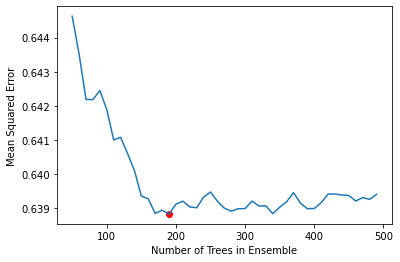

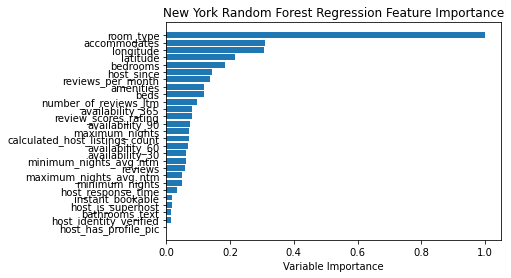

In [305]:
variables = NY_preprocessed.iloc[:, 1:].drop('price', axis=1)
target = NY_preprocessed[['price']]

variable_names = variables.columns

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)


mse0os = []
ExplainedVariance = []

rand_st = 1

nTreeList = range(50, 500, 10)

for iTrees in nTreeList:
    depth = None

    rgr = RandomForestRegressor(n_estimators=iTrees, max_features=.33, max_depth=depth, min_samples_split = 3, 
                                criterion='mse', random_state=rand_st)
    rgr.fit(data_train, target_train)

    prediction = rgr.predict(data_test)
    mse0os.append(mean_squared_error(target_test, prediction, squared=False))
    ExplainedVariance.append(explained_variance_score(target_test, prediction))

mse0os = np.array(mse0os)
min_arg = np.argmin(mse0os)
print("n_estimator which has minimum RMSE: ", nTreeList[min_arg], '\n')
print("least RMSE: ", mse0os[min_arg])
print("Explained Variance when n_estimator={}:".format(nTreeList[min_arg]), ExplainedVariance[min_arg])
 

plt.plot(nTreeList, mse0os)
plt.scatter(nTreeList[min_arg], mse0os[min_arg], color='red')
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('Mean Squared Error')

plt.show()
     
rgr = RandomForestRegressor(n_estimators=nTreeList[min_arg], max_features=.33, max_depth=depth, min_samples_split = min_samples_split, 
                                criterion='mse', random_state=rand_st)

rgr.fit(data_train, target_train)

featureImportance = rgr.feature_importances_
 
featureImportance = featureImportance / featureImportance.max()
sorted_idx = numpy.argsort(featureImportance)
barPos = numpy.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, variable_names[sorted_idx])
plt.xlabel('Variable Importance')
plt.title('New York Random Forest Regression Feature Importance')
plt.show()

In [ ]:
# San Francisco

In [294]:
SF = pd.read_csv('dataset/San Francisco, California_listings.csv')
SF_preprocessed = preprocess(SF)
SF_preprocessed = remove_outliers(SF_preprocessed)

variables = SF_preprocessed.iloc[:, 1:].drop('price', axis=1)
target = SF_preprocessed[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 

rand_st = 1

start_ts=time.time()
rgr = RandomForestRegressor(n_estimators=100, max_features=.33, max_depth=None, min_samples_split=3, criterion='mse', random_state=rand_st)
scores = cross_validate(estimator=rgr, X=data_np, y=target_np, scoring=scorers, cv=5)  

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       
scores_Expl_Var = scores['test_expl_var']
    
print("San Francisco Data")
print('='*50)
print("Random Forest RMSE: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("Random Forest Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
print("CV Runtime:", time.time()-start_ts)
print('='*50)

San Francisco Data
Random Forest RMSE: 58.58 (+/- 3.67)
Random Forest Expl Var: 0.57 (+/- 0.06)
CV Runtime: 3.9165191650390625


n_estimator which has minimum RMSE:  460 

least RMSE:  55.3911954210576
Explained Variance when n_estimator=460: 0.5993034794889534


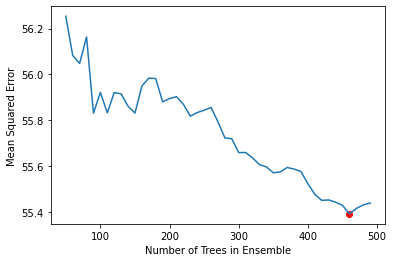

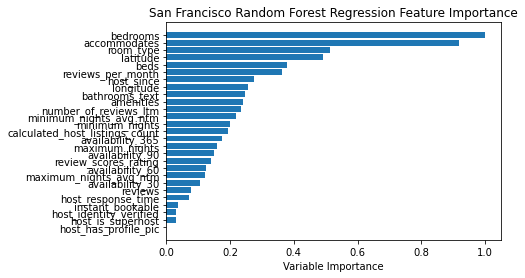

In [306]:
variables = SF_preprocessed.iloc[:, 1:].drop('price', axis=1)
target = SF_preprocessed[['price']]

variable_names = variables.columns

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

mse0os = []
ExplainedVariance = []

rand_st = 1

nTreeList = range(50, 500, 10)

for iTrees in nTreeList:
    depth = None
    rgr = RandomForestRegressor(n_estimators=iTrees, max_features=.33, max_depth=depth, min_samples_split = 3, 
                                criterion='mse', random_state=rand_st)
    rgr.fit(data_train, target_train)

    prediction = rgr.predict(data_test)
    mse0os.append(mean_squared_error(target_test, prediction, squared=False))
    ExplainedVariance.append(explained_variance_score(target_test, prediction))

mse0os = np.array(mse0os)
min_arg = np.argmin(mse0os)
print("n_estimator which has minimum RMSE: ", nTreeList[min_arg], '\n')
print("least RMSE: ", mse0os[min_arg])
print("Explained Variance when n_estimator={}:".format(nTreeList[min_arg]), ExplainedVariance[min_arg])
 

plt.plot(nTreeList, mse0os)
plt.scatter(nTreeList[min_arg], mse0os[min_arg], color='red')
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('Mean Squared Error')
plt.show()

rgr = RandomForestRegressor(n_estimators=nTreeList[min_arg], max_features=.33, max_depth=depth, min_samples_split = min_samples_split, 
                                criterion='mse', random_state=rand_st)

rgr.fit(data_train, target_train)

featureImportance = rgr.feature_importances_
 
featureImportance = featureImportance / featureImportance.max()
sorted_idx = numpy.argsort(featureImportance)
barPos = numpy.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, variable_names[sorted_idx])
plt.xlabel('Variable Importance')
plt.title('San Francisco Random Forest Regression Feature Importance')
plt.show()

In [12]:
# Jersey City

In [296]:
JC_preprocessed = preprocess(JC)
JC_preprocessed = remove_outliers(JC_preprocessed)

variables = JC_preprocessed.iloc[:, 1:].drop('price', axis=1)
target = JC_preprocessed[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 

rand_st = 1

start_ts=time.time()
rgr = RandomForestRegressor(n_estimators=100, max_features=.33, max_depth=None, min_samples_split=3, criterion='mse', random_state=rand_st)
scores = cross_validate(estimator=rgr, X=data_np, y=target_np, scoring=scorers, cv=5)  

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       
scores_Expl_Var = scores['test_expl_var']
    
print("Jersey City Data")
print('='*50)
print("Random Forest RMSE: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("Random Forest Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
print("CV Runtime:", time.time()-start_ts)
print('='*50)

Jersey City Data
Random Forest RMSE: 32.12 (+/- 10.84)
Random Forest Expl Var: 0.67 (+/- 0.18)
CV Runtime: 1.9803295135498047


n_estimator which has minimum RMSE:  160 

least RMSE:  25.702592163751998
Explained Variance when n_estimator=160: 0.7585571602655943


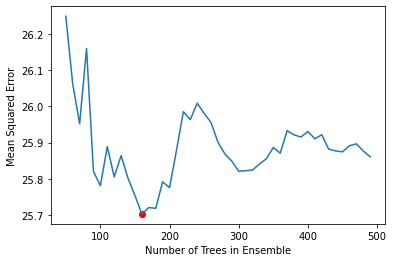

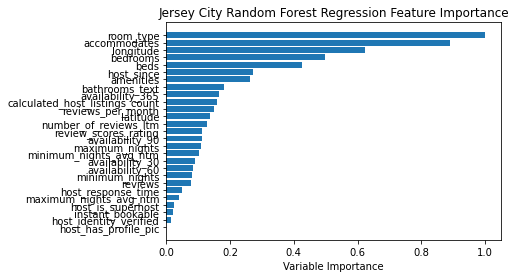

In [307]:
variables = JC_preprocessed.iloc[:, 1:].drop('price', axis=1)
target = JC_preprocessed[['price']]

variable_names = variables.columns

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

mse0os = []
ExplainedVariance = []

rand_st = 1

nTreeList = range(50, 500, 10)

for iTrees in nTreeList:
    depth = None
    rgr = RandomForestRegressor(n_estimators=iTrees, max_features=.33, max_depth=depth, min_samples_split = 3, 
                                criterion='mse', random_state=rand_st)
    rgr.fit(data_train, target_train)

    prediction = rgr.predict(data_test)
    mse0os.append(mean_squared_error(target_test, prediction, squared=False))
    ExplainedVariance.append(explained_variance_score(target_test, prediction))

mse0os = np.array(mse0os)
min_arg = np.argmin(mse0os)
print("n_estimator which has minimum RMSE: ", nTreeList[min_arg], '\n')
print("least RMSE: ", mse0os[min_arg])
print("Explained Variance when n_estimator={}:".format(nTreeList[min_arg]), ExplainedVariance[min_arg])
 
plt.plot(nTreeList, mse0os)
plt.scatter(nTreeList[min_arg], mse0os[min_arg], color='red')
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('Mean Squared Error')
plt.show()

rgr = RandomForestRegressor(n_estimators=nTreeList[min_arg], max_features=.33, max_depth=depth, min_samples_split = min_samples_split, 
                                criterion='mse', random_state=rand_st)

rgr.fit(data_train, target_train)

featureImportance = rgr.feature_importances_
 
featureImportance = featureImportance / featureImportance.max()
sorted_idx = numpy.argsort(featureImportance)
barPos = numpy.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, variable_names[sorted_idx])
plt.xlabel('Variable Importance')
plt.title('Jersey City Random Forest Regression Feature Importance')
plt.show()

In [15]:
# Hawaii

In [298]:
HI_preprocessed = preprocess(HI)
HI_preprocessed = remove_outliers(HI_preprocessed)

variables = HI_preprocessed.iloc[:, 1:].drop('price', axis=1)
target = HI_preprocessed[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 

rand_st = 1

start_ts=time.time()
rgr = RandomForestRegressor(n_estimators=100, max_features=.33, max_depth=None, min_samples_split=3, criterion='mse', random_state=rand_st)
scores = cross_validate(estimator=rgr, X=data_np, y=target_np, scoring=scorers, cv=5)  

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       
scores_Expl_Var = scores['test_expl_var']
    
print("Hawaii Data")
print('='*50)
print("Random Forest RMSE: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("Random Forest Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
print("CV Runtime:", time.time()-start_ts)
print('='*50)

Hawaii Data
Random Forest RMSE: 66.27 (+/- 3.49)
Random Forest Expl Var: 0.60 (+/- 0.06)
CV Runtime: 12.990850687026978


n_estimator which has minimum RMSE:  490 

least RMSE:  61.36325717505671
Explained Variance when n_estimator=490: 0.6341798611033126


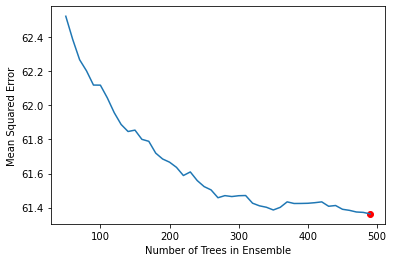

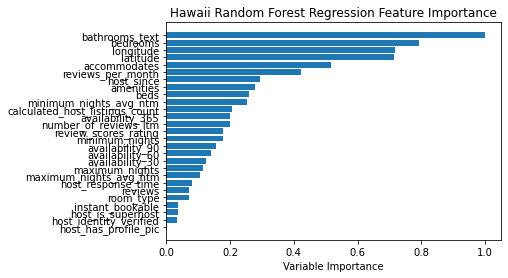

In [308]:
variables = HI_preprocessed.iloc[:, 1:].drop('price', axis=1)
target = HI_preprocessed[['price']]

variable_names = variables.columns

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

mse0os = []
ExplainedVariance = []

rand_st = 1

nTreeList = range(50, 500, 10)

for iTrees in nTreeList:
    depth = None
    rgr = RandomForestRegressor(n_estimators=iTrees, max_features=.33, max_depth=depth, min_samples_split = 3, 
                                criterion='mse', random_state=rand_st)
    rgr.fit(data_train, target_train)

    prediction = rgr.predict(data_test)
    mse0os.append(mean_squared_error(target_test, prediction, squared=False))
    ExplainedVariance.append(explained_variance_score(target_test, prediction))

mse0os = np.array(mse0os)
min_arg = np.argmin(mse0os)
print("n_estimator which has minimum RMSE: ", nTreeList[min_arg], '\n')
print("least RMSE: ", mse0os[min_arg])
print("Explained Variance when n_estimator={}:".format(nTreeList[min_arg]), ExplainedVariance[min_arg])
 
plt.plot(nTreeList, mse0os)
plt.scatter(nTreeList[min_arg], mse0os[min_arg], color='red')
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('Mean Squared Error')
plt.show()
 
rgr = RandomForestRegressor(n_estimators=nTreeList[min_arg], max_features=.33, max_depth=depth, min_samples_split = min_samples_split, 
                                criterion='mse', random_state=rand_st)

rgr.fit(data_train, target_train)

featureImportance = rgr.feature_importances_
 
featureImportance = featureImportance / featureImportance.max()
sorted_idx = numpy.argsort(featureImportance)
barPos = numpy.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, variable_names[sorted_idx])
plt.xlabel('Variable Importance')
plt.title('Hawaii Random Forest Regression Feature Importance')
plt.show()

In [18]:
# Santa Clara County

In [300]:
SCC_preprocessed = preprocess(SCC)
SCC_preprocessed = remove_outliers(SCC_preprocessed)

variables = SCC_preprocessed.iloc[:, 1:].drop('price', axis=1)
target = SCC_preprocessed[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 

rand_st = 1

start_ts=time.time()
rgr = RandomForestRegressor(n_estimators=100, max_features=.33, max_depth=None, min_samples_split=3, criterion='mse', random_state=rand_st)
scores = cross_validate(estimator=rgr, X=data_np, y=target_np, scoring=scorers, cv=5)  

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       
scores_Expl_Var = scores['test_expl_var']
    
print("Santa Clara County")
print('='*50)
print("Random Forest RMSE: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("Random Forest Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
print("CV Runtime:", time.time()-start_ts)
print('='*50)

Santa Clara County
Random Forest RMSE: 34.87 (+/- 4.36)
Random Forest Expl Var: 0.74 (+/- 0.08)
CV Runtime: 3.1360597610473633


n_estimator which has minimum RMSE:  390 

least RMSE:  35.227273780656574
Explained Variance when n_estimator=390: 0.7461114150135544


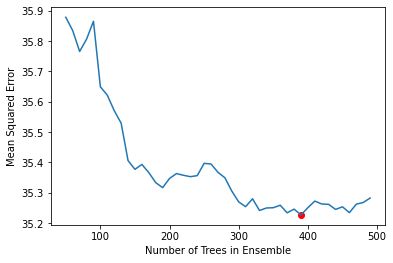

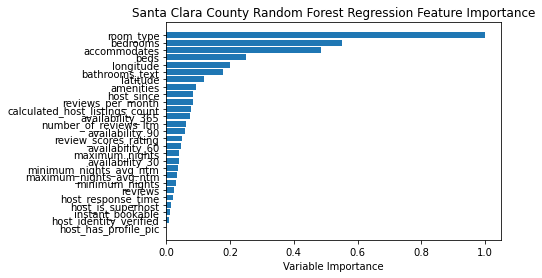

In [309]:
variables = SCC_preprocessed.iloc[:, 1:].drop('price', axis=1)
target = SCC_preprocessed[['price']]

variable_names = variables.columns

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

mse0os = []
ExplainedVariance = []

rand_st = 1

nTreeList = range(50, 500, 10)

for iTrees in nTreeList:
    depth = None
    rgr = RandomForestRegressor(n_estimators=iTrees, max_features=.33, max_depth=depth, min_samples_split = 3, 
                                criterion='mse', random_state=rand_st)
    rgr.fit(data_train, target_train)

    prediction = rgr.predict(data_test)
    mse0os.append(mean_squared_error(target_test, prediction, squared=False))
    ExplainedVariance.append(explained_variance_score(target_test, prediction))

mse0os = np.array(mse0os)
min_arg = np.argmin(mse0os)
print("n_estimator which has minimum RMSE: ", nTreeList[min_arg], '\n')
print("least RMSE: ", mse0os[min_arg])
print("Explained Variance when n_estimator={}:".format(nTreeList[min_arg]), ExplainedVariance[min_arg])
 
plt.plot(nTreeList, mse0os)
plt.scatter(nTreeList[min_arg], mse0os[min_arg], color='red')
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('Mean Squared Error')
plt.show()
 
rgr = RandomForestRegressor(n_estimators=nTreeList[min_arg], max_features=.33, max_depth=depth, min_samples_split = min_samples_split, 
                                criterion='mse', random_state=rand_st)

rgr.fit(data_train, target_train)

featureImportance = rgr.feature_importances_
 
featureImportance = featureImportance / featureImportance.max()
sorted_idx = numpy.argsort(featureImportance)
barPos = numpy.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, variable_names[sorted_idx])
plt.xlabel('Variable Importance')
plt.title('Santa Clara County Random Forest Regression Feature Importance')
plt.show()

In [21]:
# Clark County

In [302]:
CC_preprocessed = preprocess(CC)
CC_preprocessed = remove_outliers(CC_preprocessed)

variables = CC_preprocessed.iloc[:, 1:].drop('price', axis=1)
target = CC_preprocessed[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 

rand_st = 1

start_ts=time.time()
rgr = RandomForestRegressor(n_estimators=100, max_features=.33, max_depth=None, min_samples_split=3, criterion='mse', random_state=rand_st)
scores = cross_validate(estimator=rgr, X=data_np, y=target_np, scoring=scorers, cv=5)  

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       
scores_Expl_Var = scores['test_expl_var']
    
print("Clark County Data")    
print('='*50)
print("Random Forest RMSE: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("Random Forest Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
print("CV Runtime:", time.time()-start_ts)
print('='*50)

Clark County Data
Random Forest RMSE: 54.53 (+/- 5.36)
Random Forest Expl Var: 0.69 (+/- 0.07)
CV Runtime: 5.0639307498931885


n_estimator which has minimum RMSE:  370 

least RMSE:  51.66466114927496
Explained Variance when n_estimator=370: 0.7289870927959783


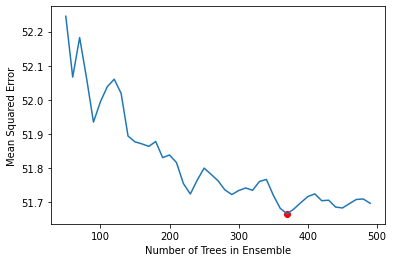

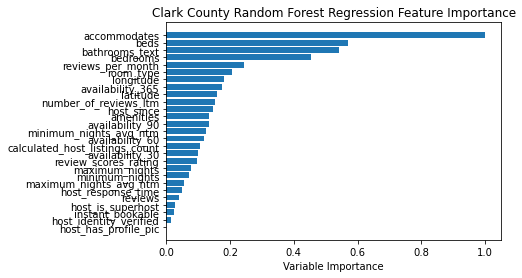

In [310]:
variables = CC_preprocessed.iloc[:, 1:].drop('price', axis=1)
target = CC_preprocessed[['price']]

variable_names = variables.columns

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

mse0os = []
ExplainedVariance = []

rand_st = 1

nTreeList = range(50, 500, 10)

for iTrees in nTreeList:
    depth = None
    rgr = RandomForestRegressor(n_estimators=iTrees, max_features=.33, max_depth=depth, min_samples_split = 3, 
                                criterion='mse', random_state=rand_st)
    rgr.fit(data_train, target_train)

    prediction = rgr.predict(data_test)
    mse0os.append(mean_squared_error(target_test, prediction, squared=False))
    ExplainedVariance.append(explained_variance_score(target_test, prediction))

mse0os = np.array(mse0os)
min_arg = np.argmin(mse0os)
print("n_estimator which has minimum RMSE: ", nTreeList[min_arg], '\n')
print("least RMSE: ", mse0os[min_arg])
print("Explained Variance when n_estimator={}:".format(nTreeList[min_arg]), ExplainedVariance[min_arg])

plt.plot(nTreeList, mse0os)
plt.scatter(nTreeList[min_arg], mse0os[min_arg], color='red')
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('Mean Squared Error')
plt.show()
 
rgr = RandomForestRegressor(n_estimators=nTreeList[min_arg], max_features=.33, max_depth=depth, min_samples_split = min_samples_split, 
                                criterion='mse', random_state=rand_st)

rgr.fit(data_train, target_train)

featureImportance = rgr.feature_importances_
 
featureImportance = featureImportance / featureImportance.max()
sorted_idx = numpy.argsort(featureImportance)
barPos = numpy.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, variable_names[sorted_idx])
plt.xlabel('Variable Importance')
plt.title('Clark County Random Forest Regression Feature Importance')
plt.show()

### Classification

# Target을 Classification할 수 있도록 만들어주는 함수

In [170]:
# balance하게 label을 지정해주기 위해 50% 값을 기준으로 잘라줌

def to_category(df):
    middle = df[['price']].describe().loc['50%',:][0]
    df.loc[df['price'] < middle, 'price'] = -1
    df.loc[df['price'] >= middle, 'price'] = 1
    
    return df

In [109]:
# New York

In [155]:
NY = pd.read_csv('dataset/New York City, New York_listings.csv')
NY_preprocessed = preprocess(NY)
NY_preprocessed = remove_outliers(NY_preprocessed)

In [304]:
NY_preprocessed_c = to_category(NY_preprocessed)

variables = NY_preprocessed_c.iloc[:, 1:].drop('price', axis=1)
target = NY_preprocessed_c[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)


rand_st = 1

start_ts=time.time()
clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=3, criterion='entropy', random_state=rand_st)

scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}

scores = cross_validate(estimator=clf, X=data_np, y=target_np, scoring = scorers, cv=5)

scores_Acc = scores['test_Accuracy']        

print("NewYork Data")
print('='*50)
print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    

scores_AUC = scores['test_roc_auc']                                                                                     

print("Random Forest AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
print("CV Runtime:", time.time()-start_ts)
print('='*50)

NewYork Data
Random Forest Acc: 0.85 (+/- 0.01)
Random Forest AUC: 0.93 (+/- 0.00)
CV Runtime: 10.297922372817993


n_estimator which has maximum ACC:  470 

Maximum ACC:  0.8660795627087762
AUC when n_estimator=470: 0.8660892268784315


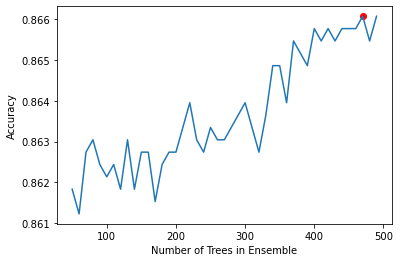

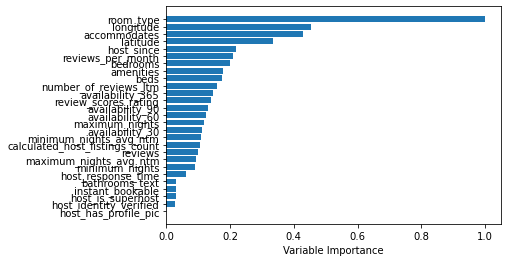

In [220]:
NY_preprocessed_c = to_category(NY_preprocessed)

variables = NY_preprocessed_c.iloc[:, 1:].drop('price', axis=1)
target = NY_preprocessed_c[['price']]

variable_names = variables.columns

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

ACC = []
AUC = []

rand_st = 1

nTreeList = range(50, 500, 10)

for iTrees in nTreeList:
    depth = None
    clf = RandomForestClassifier(n_estimators=iTrees, max_depth=None, min_samples_split=3, criterion='entropy', random_state=rand_st)
    
    clf.fit(data_train, target_train)

    prediction = clf.predict(data_test)
    ACC.append(accuracy_score(target_test, prediction))
    AUC.append(roc_auc_score(target_test, prediction))

ACC = np.array(ACC)
max_arg = np.argmax(ACC)
print("n_estimator which has maximum ACC: ", nTreeList[max_arg], '\n')
print("Maximum ACC: ", ACC[max_arg])
print("AUC when n_estimator={}:".format(nTreeList[max_arg]), AUC[max_arg])
 
plt.plot(nTreeList, ACC)
plt.scatter(nTreeList[max_arg], ACC[max_arg], color='red')
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('Accuracy')
plt.show()

clf = RandomForestClassifier(n_estimators=nTreeList[max_arg], max_depth=None, min_samples_split=3, criterion='entropy', random_state=rand_st)

clf.fit(data_train, target_train)

featureImportance = clf.feature_importances_
 
featureImportance = featureImportance / featureImportance.max()
sorted_idx = numpy.argsort(featureImportance)
barPos = numpy.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, variable_names[sorted_idx])
plt.xlabel('Variable Importance')
plt.title('New York Random Forest Classification Feature Importance')
plt.show()

In [128]:
# San Francisco

In [174]:
SF = pd.read_csv('dataset/San Francisco, California_listings.csv')
SF_preprocessed = preprocess(SF)
SF_preprocessed = remove_outliers(SF_preprocessed)

In [311]:
SF_preprocessed_c = to_category(SF_preprocessed)

variables = SF_preprocessed_c.iloc[:, 1:].drop('price', axis=1)
target = SF_preprocessed_c[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)


rand_st = 1

start_ts=time.time()
clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=3, criterion='entropy', random_state=rand_st)

scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}

scores = cross_validate(estimator=clf, X=data_np, y=target_np, scoring = scorers, cv=5)

scores_Acc = scores['test_Accuracy']        

print("San Francisco Data")
print('='*50)
print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    

scores_AUC = scores['test_roc_auc']                                                                      

print("Random Forest AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
print("CV Runtime:", time.time()-start_ts)
print('='*50)

San Francisco Data
Random Forest Acc: 0.80 (+/- 0.05)
Random Forest AUC: 0.88 (+/- 0.04)
CV Runtime: 3.0907020568847656


n_estimator which has maximum ACC:  250 

Maximum ACC:  0.8192771084337349
AUC when n_estimator=250: 0.8192771084337349


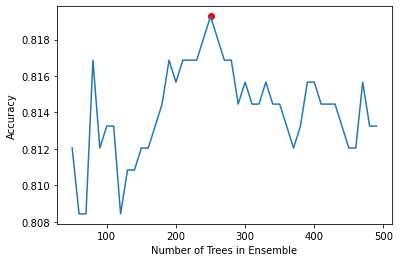

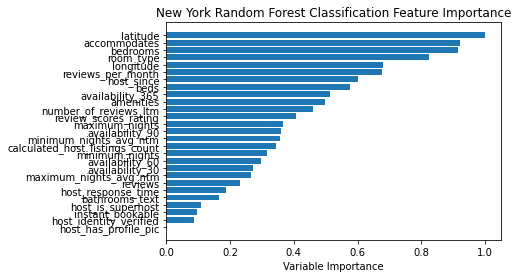

In [312]:
SF_preprocessed_c = to_category(SF_preprocessed)

variables = SF_preprocessed_c.iloc[:, 1:].drop('price', axis=1)
target = SF_preprocessed_c[['price']]

variable_names = variables.columns

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

ACC = []
AUC = []

rand_st = 1

nTreeList = range(50, 500, 10)

for iTrees in nTreeList:
    depth = None
    clf = RandomForestClassifier(n_estimators=iTrees, max_depth=None, min_samples_split=3, criterion='entropy', random_state=rand_st)
    
    clf.fit(data_train, target_train)

    prediction = clf.predict(data_test)
    ACC.append(accuracy_score(target_test, prediction))
    AUC.append(roc_auc_score(target_test, prediction))

ACC = np.array(ACC)
max_arg = np.argmax(ACC)
print("n_estimator which has maximum ACC: ", nTreeList[max_arg], '\n')
print("Maximum ACC: ", ACC[max_arg])
print("AUC when n_estimator={}:".format(nTreeList[max_arg]), AUC[max_arg])
 
plt.plot(nTreeList, ACC)
plt.scatter(nTreeList[max_arg], ACC[max_arg], color='red')
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('Accuracy')
plt.show()

clf = RandomForestClassifier(n_estimators=nTreeList[max_arg], max_depth=None, min_samples_split=3, criterion='entropy', random_state=rand_st)

clf.fit(data_train, target_train)

featureImportance = clf.feature_importances_
 
featureImportance = featureImportance / featureImportance.max()
sorted_idx = numpy.argsort(featureImportance)
barPos = numpy.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, variable_names[sorted_idx])
plt.xlabel('Variable Importance')
plt.title('New York Random Forest Classification Feature Importance')
plt.show()

In [133]:
# Jersey City

In [177]:
JC = pd.read_csv('dataset/Jersey City, New Jersey_listings.csv')
JC_preprocessed = preprocess(JC)
JC_preprocessed = remove_outliers(JC_preprocessed)

In [313]:
JC_preprocessed_c = to_category(JC_preprocessed)

variables = JC_preprocessed_c.iloc[:, 1:].drop('price', axis=1)
target = JC_preprocessed_c[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)


rand_st = 1

start_ts=time.time()
clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=3, criterion='entropy', random_state=rand_st)

scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}

scores = cross_validate(estimator=clf, X=data_np, y=target_np, scoring = scorers, cv=5)

scores_Acc = scores['test_Accuracy']        

print("Jersey City Data")
print('='*50)
print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    

scores_AUC = scores['test_roc_auc']                                                                     

print("Random Forest AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
print("CV Runtime:", time.time()-start_ts)
print('='*50)

Jersey City Data
Random Forest Acc: 0.86 (+/- 0.10)
Random Forest AUC: 0.94 (+/- 0.06)
CV Runtime: 1.3818471431732178


n_estimator which has maximum ACC:  80 

Maximum ACC:  0.8325581395348837
AUC when n_estimator=80: 0.829732778066979


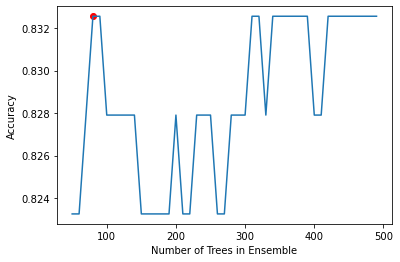

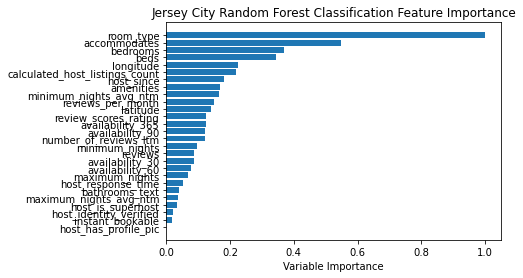

In [316]:
JC_preprocessed_c = to_category(JC_preprocessed)

variables = JC_preprocessed_c.iloc[:, 1:].drop('price', axis=1)
target = JC_preprocessed_c[['price']]

variable_names = variables.columns

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

ACC = []
AUC = []

rand_st = 1

nTreeList = range(50, 500, 10)

for iTrees in nTreeList:
    depth = None
    clf = RandomForestClassifier(n_estimators=iTrees, max_depth=None, min_samples_split=3, criterion='entropy', random_state=rand_st)
    
    clf.fit(data_train, target_train)

    prediction = clf.predict(data_test)
    ACC.append(accuracy_score(target_test, prediction))
    AUC.append(roc_auc_score(target_test, prediction))

ACC = np.array(ACC)
max_arg = np.argmax(ACC)
print("n_estimator which has maximum ACC: ", nTreeList[max_arg], '\n')
print("Maximum ACC: ", ACC[max_arg])
print("AUC when n_estimator={}:".format(nTreeList[max_arg]), AUC[max_arg])
 
plt.plot(nTreeList, ACC)
plt.scatter(nTreeList[max_arg], ACC[max_arg], color='red')
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('Accuracy')
plt.show()

clf = RandomForestClassifier(n_estimators=nTreeList[max_arg], max_depth=None, min_samples_split=3, criterion='entropy', random_state=rand_st)

clf.fit(data_train, target_train)

featureImportance = clf.feature_importances_
 
featureImportance = featureImportance / featureImportance.max()
sorted_idx = numpy.argsort(featureImportance)
barPos = numpy.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, variable_names[sorted_idx])
plt.xlabel('Variable Importance')
plt.title('Jersey City Random Forest Classification Feature Importance')
plt.show()

In [ ]:
# Hawaii

In [179]:
HI = pd.read_csv('dataset/Hawaii, Hawaii_listings.csv')
HI_preprocessed = preprocess(HI)
HI_preprocessed = remove_outliers(HI_preprocessed)

In [315]:
HI_preprocessed_c = to_category(HI_preprocessed)

variables = HI_preprocessed_c.iloc[:, 1:].drop('price', axis=1)
target = HI_preprocessed_c[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)


rand_st = 1

start_ts=time.time()
clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=3, criterion='entropy', random_state=rand_st)

scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}

scores = cross_validate(estimator=clf, X=data_np, y=target_np, scoring = scorers, cv=5)

scores_Acc = scores['test_Accuracy']        

print("Hawaii Data")
print('='*50)
print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    

scores_AUC = scores['test_roc_auc']                                                                     

print("Random Forest AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
print("CV Runtime:", time.time()-start_ts)
print('='*50)

Hawaii Data
Random Forest Acc: 0.81 (+/- 0.02)
Random Forest AUC: 0.90 (+/- 0.03)
CV Runtime: 8.733570098876953


n_estimator which has maximum ACC:  190 

Maximum ACC:  0.8453837597330367
AUC when n_estimator=190: 0.8453887491462377


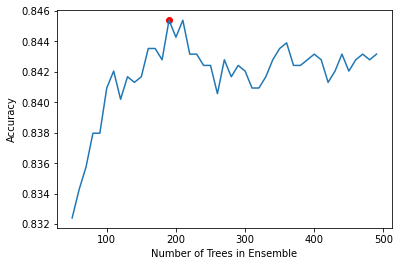

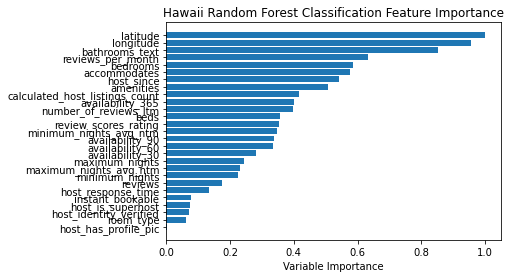

In [317]:
HI_preprocessed_c = to_category(HI_preprocessed)

variables = HI_preprocessed_c.iloc[:, 1:].drop('price', axis=1)
target = HI_preprocessed_c[['price']]

variable_names = variables.columns

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

ACC = []
AUC = []

rand_st = 1

nTreeList = range(50, 500, 10)

for iTrees in nTreeList:
    depth = None
    clf = RandomForestClassifier(n_estimators=iTrees, max_depth=None, min_samples_split=3, criterion='entropy', random_state=rand_st)
    
    clf.fit(data_train, target_train)

    prediction = clf.predict(data_test)
    ACC.append(accuracy_score(target_test, prediction))
    AUC.append(roc_auc_score(target_test, prediction))

ACC = np.array(ACC)
max_arg = np.argmax(ACC)
print("n_estimator which has maximum ACC: ", nTreeList[max_arg], '\n')
print("Maximum ACC: ", ACC[max_arg])
print("AUC when n_estimator={}:".format(nTreeList[max_arg]), AUC[max_arg])
 
plt.plot(nTreeList, ACC)
plt.scatter(nTreeList[max_arg], ACC[max_arg], color='red')
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('Accuracy')
plt.show()

clf = RandomForestClassifier(n_estimators=nTreeList[max_arg], max_depth=None, min_samples_split=3, criterion='entropy', random_state=rand_st)

clf.fit(data_train, target_train)

featureImportance = clf.feature_importances_
 
featureImportance = featureImportance / featureImportance.max()
sorted_idx = numpy.argsort(featureImportance)
barPos = numpy.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, variable_names[sorted_idx])
plt.xlabel('Variable Importance')
plt.title('Hawaii Random Forest Classification Feature Importance')
plt.show()

In [140]:
# Santa Clara County

In [181]:
SCC = pd.read_csv('dataset/Santa Clara County, California_listings.csv')
SCC_preprocessed = preprocess(SCC)
SCC_preprocessed = remove_outliers(SCC_preprocessed)

In [318]:
SCC_preprocessed_c = to_category(SCC_preprocessed)

variables = SCC_preprocessed_c.iloc[:, 1:].drop('price', axis=1)
target = SCC_preprocessed_c[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)


rand_st = 1

start_ts=time.time()
clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=3, criterion='entropy', random_state=rand_st)

scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}

scores = cross_validate(estimator=clf, X=data_np, y=target_np, scoring = scorers, cv=5)

scores_Acc = scores['test_Accuracy']        

print("Santa Clara County Data")
print('='*50)
print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    

scores_AUC = scores['test_roc_auc']                                                                    

print("Random Forest AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
print("CV Runtime:", time.time()-start_ts)
print('='*50)

Santa Clara County Data
Random Forest Acc: 0.89 (+/- 0.06)
Random Forest AUC: 0.94 (+/- 0.04)
CV Runtime: 2.1258411407470703


n_estimator which has maximum ACC:  50 

Maximum ACC:  0.8920118343195266
AUC when n_estimator=50: 0.8932359871411928


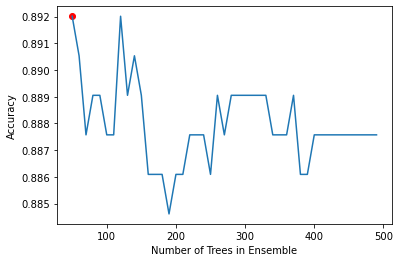

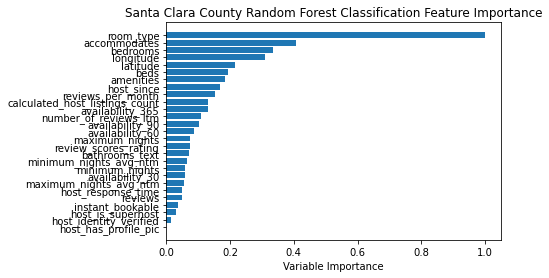

In [319]:
SCC_preprocessed_c = to_category(SCC_preprocessed)

variables = SCC_preprocessed_c.iloc[:, 1:].drop('price', axis=1)
target = SCC_preprocessed_c[['price']]

variable_names = variables.columns

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

ACC = []
AUC = []

rand_st = 1

nTreeList = range(50, 500, 10)

for iTrees in nTreeList:
    depth = None
    clf = RandomForestClassifier(n_estimators=iTrees, max_depth=None, min_samples_split=3, criterion='entropy', random_state=rand_st)
    
    clf.fit(data_train, target_train)

    prediction = clf.predict(data_test)
    ACC.append(accuracy_score(target_test, prediction))
    AUC.append(roc_auc_score(target_test, prediction))

ACC = np.array(ACC)
max_arg = np.argmax(ACC)
print("n_estimator which has maximum ACC: ", nTreeList[max_arg], '\n')
print("Maximum ACC: ", ACC[max_arg])
print("AUC when n_estimator={}:".format(nTreeList[max_arg]), AUC[max_arg])
 
plt.plot(nTreeList, ACC)
plt.scatter(nTreeList[max_arg], ACC[max_arg], color='red')
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('Accuracy')
plt.show()

clf = RandomForestClassifier(n_estimators=nTreeList[max_arg], max_depth=None, min_samples_split=3, criterion='entropy', random_state=rand_st)

clf.fit(data_train, target_train)

featureImportance = clf.feature_importances_
 
featureImportance = featureImportance / featureImportance.max()
sorted_idx = numpy.argsort(featureImportance)
barPos = numpy.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, variable_names[sorted_idx])
plt.xlabel('Variable Importance')
plt.title('Santa Clara County Random Forest Classification Feature Importance')
plt.show()

In [183]:
# Clark County

In [ ]:
CC = pd.read_csv('dataset/Clark County, NV, Nevada_listings.csv')
CC_preprocessed = preprocess(CC)
CC_preprocessed = remove_outliers(CC_preprocessed)

In [320]:
CC_preprocessed_c = to_category(CC_preprocessed)

variables = CC_preprocessed_c.iloc[:, 1:].drop('price', axis=1)
target = CC_preprocessed_c[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)


rand_st = 1

start_ts=time.time()
clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=3, criterion='entropy', random_state=rand_st)

scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}

scores = cross_validate(estimator=clf, X=data_np, y=target_np, scoring = scorers, cv=5)

scores_Acc = scores['test_Accuracy']        

print("Clark County Data")
print('='*50)
print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    

scores_AUC = scores['test_roc_auc']                                                                     

print("Random Forest AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
print("CV Runtime:", time.time()-start_ts)
print('='*50)

Clark County Data
Random Forest Acc: 0.87 (+/- 0.04)
Random Forest AUC: 0.94 (+/- 0.02)
CV Runtime: 3.434548854827881


n_estimator which has maximum ACC:  250 

Maximum ACC:  0.8926056338028169
AUC when n_estimator=250: 0.8923265830085301


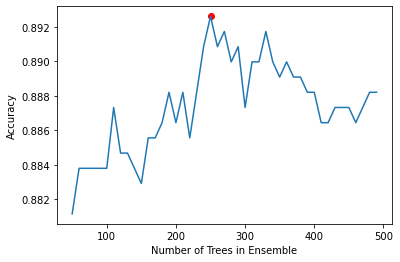

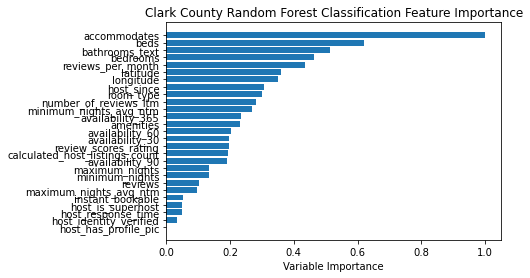

In [321]:
CC_preprocessed_c = to_category(CC_preprocessed)

variables = CC_preprocessed_c.iloc[:, 1:].drop('price', axis=1)
target = CC_preprocessed_c[['price']]

variable_names = variables.columns

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

ACC = []
AUC = []

rand_st = 1

nTreeList = range(50, 500, 10)

for iTrees in nTreeList:
    depth = None
    clf = RandomForestClassifier(n_estimators=iTrees, max_depth=None, min_samples_split=3, criterion='entropy', random_state=rand_st)
    
    clf.fit(data_train, target_train)

    prediction = clf.predict(data_test)
    ACC.append(accuracy_score(target_test, prediction))
    AUC.append(roc_auc_score(target_test, prediction))

ACC = np.array(ACC)
max_arg = np.argmax(ACC)
print("n_estimator which has maximum ACC: ", nTreeList[max_arg], '\n')
print("Maximum ACC: ", ACC[max_arg])
print("AUC when n_estimator={}:".format(nTreeList[max_arg]), AUC[max_arg])
 
plt.plot(nTreeList, ACC)
plt.scatter(nTreeList[max_arg], ACC[max_arg], color='red')
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('Accuracy')
plt.show()

clf = RandomForestClassifier(n_estimators=nTreeList[max_arg], max_depth=None, min_samples_split=3, criterion='entropy', random_state=rand_st)

clf.fit(data_train, target_train)

featureImportance = clf.feature_importances_
 
featureImportance = featureImportance / featureImportance.max()
sorted_idx = numpy.argsort(featureImportance)
barPos = numpy.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, variable_names[sorted_idx])
plt.xlabel('Variable Importance')
plt.title('Clark County Random Forest Classification Feature Importance')
plt.show()

## 2. Gradieng Boosting (LightBGM)

### Regression

In [237]:
# New York

In [322]:
NY_preprocessed = preprocess(NY)
NY_preprocessed = remove_outliers(NY_preprocessed)

variables = NY_preprocessed.iloc[:, 1:].drop('price', axis=1)
target = NY_preprocessed[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 

rand_st = 1

start_ts=time.time()

hyper_params = {'boosting_type': 'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": 100}

gbm = lgb.LGBMRegressor(**hyper_params, random_state=1)

scores = cross_validate(estimator=gbm, X=data_np, y=target_np, scoring=scorers, cv=5)  

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       
scores_Expl_Var = scores['test_expl_var']
    
print("NewYork Data")    
print('='*50)
print("Light GBM RMSE: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("Light GBM Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
print("CV Runtime:", time.time()-start_ts)
print('='*50)


NewYork Data
Light GBM RMSE: 40.12 (+/- 3.25)
Light GBM Expl Var: 0.63 (+/- 0.05)
CV Runtime: 0.47367143630981445


n_estimator which has minimum RMSE:  350 

least RMSE:  39.20044095742117
Explained Variance when n_estimator=350: 0.6380209994296782


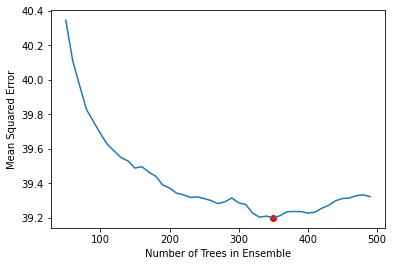

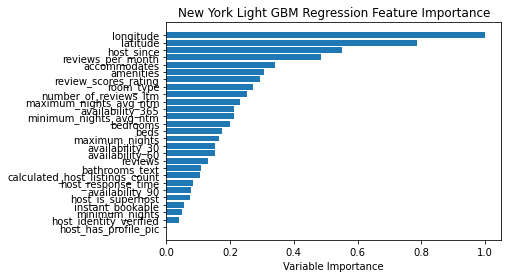

In [323]:
NY_preprocessed = preprocess(NY)
NY_preprocessed = remove_outliers(NY_preprocessed)

variables = NY_preprocessed.iloc[:, 1:].drop('price', axis=1)
target = NY_preprocessed[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

mse0os = []
ExplainedVariance = []

rand_st = 1

nTreeList = range(50, 500, 10)

for iTrees in nTreeList:
    depth = None

    hyper_params = {'boosting_type': 'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": iTrees}

    gbm = lgb.LGBMRegressor(**hyper_params, random_state=1)
    gbm.fit(data_train, target_train)

    prediction = gbm.predict(data_test)
    mse0os.append(mean_squared_error(target_test, prediction, squared=False))
    ExplainedVariance.append(explained_variance_score(target_test, prediction))

mse0os = np.array(mse0os)
min_arg = np.argmin(mse0os)
print("n_estimator which has minimum RMSE: ", nTreeList[min_arg], '\n')
print("least RMSE: ", mse0os[min_arg])
print("Explained Variance when n_estimator={}:".format(nTreeList[min_arg]), ExplainedVariance[min_arg])
 
plt.plot(nTreeList, mse0os)
plt.scatter(nTreeList[min_arg], mse0os[min_arg], color='red')
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('Mean Squared Error')
plt.show()
    
hyper_params = {'boosting_type': 'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": nTreeList[min_arg]}

gbm = lgb.LGBMRegressor(**hyper_params, random_state=1)
gbm.fit(data_train, target_train)

featureImportance = gbm.feature_importances_
 
featureImportance = featureImportance / featureImportance.max()
sorted_idx = numpy.argsort(featureImportance)
barPos = numpy.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, variable_names[sorted_idx])
plt.xlabel('Variable Importance')
plt.title('New York Light GBM Regression Feature Importance')
plt.show()

In [239]:
# San Francisco

In [324]:
SF_preprocessed = preprocess(SF)
SF_preprocessed = remove_outliers(SF_preprocessed)

variables = SF_preprocessed.iloc[:, 1:].drop('price', axis=1)
target = SF_preprocessed[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 

rand_st = 1

start_ts=time.time()

hyper_params = {'boosting_type': 'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": 100}

gbm = lgb.LGBMRegressor(**hyper_params, random_state=1)

scores = cross_validate(estimator=gbm, X=data_np, y=target_np, scoring=scorers, cv=5)  

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       
scores_Expl_Var = scores['test_expl_var']
    
print("San Francisco Data")    
print('='*50)
print("Light GBM RMSE: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("Light GBM Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
print("CV Runtime:", time.time()-start_ts)
print('='*50)


San Francisco Data
Light GBM RMSE: 57.56 (+/- 2.83)
Light GBM Expl Var: 0.58 (+/- 0.06)
CV Runtime: 0.2590970993041992


n_estimator which has minimum RMSE:  140 

least RMSE:  57.53194348999328
Explained Variance when n_estimator=140: 0.5996651975179281


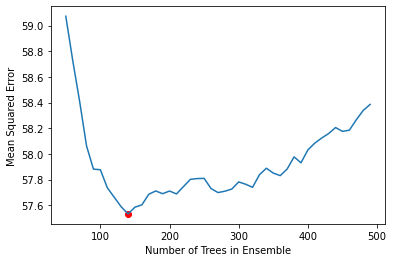

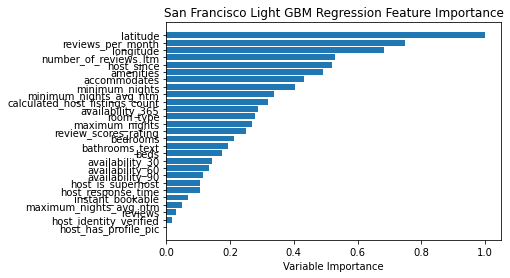

In [325]:
SF_preprocessed = preprocess(SF)
SF_preprocessed = remove_outliers(SF_preprocessed)

variables = SF_preprocessed.iloc[:, 1:].drop('price', axis=1)
target = SF_preprocessed[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

mse0os = []
ExplainedVariance = []

rand_st = 1

nTreeList = range(50, 500, 10)

for iTrees in nTreeList:
    depth = None

    hyper_params = {'boosting_type': 'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": iTrees}

    gbm = lgb.LGBMRegressor(**hyper_params, random_state=1)
    gbm.fit(data_train, target_train)

    prediction = gbm.predict(data_test)
    mse0os.append(mean_squared_error(target_test, prediction, squared=False))
    ExplainedVariance.append(explained_variance_score(target_test, prediction))

mse0os = np.array(mse0os)
min_arg = np.argmin(mse0os)
print("n_estimator which has minimum RMSE: ", nTreeList[min_arg], '\n')
print("least RMSE: ", mse0os[min_arg])
print("Explained Variance when n_estimator={}:".format(nTreeList[min_arg]), ExplainedVariance[min_arg])
 
plt.plot(nTreeList, mse0os)
plt.scatter(nTreeList[min_arg], mse0os[min_arg], color='red')
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('Mean Squared Error')
plt.show()
 
hyper_params = {'boosting_type': 'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": nTreeList[min_arg]}

gbm = lgb.LGBMRegressor(**hyper_params, random_state=1)
gbm.fit(data_train, target_train)

featureImportance = gbm.feature_importances_
 
featureImportance = featureImportance / featureImportance.max()
sorted_idx = numpy.argsort(featureImportance)
barPos = numpy.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, variable_names[sorted_idx])
plt.xlabel('Variable Importance')
plt.title('San Francisco Light GBM Regression Feature Importance')
plt.show()

In [241]:
# Jersey City

In [326]:
JC_preprocessed = preprocess(JC)
JC_preprocessed = remove_outliers(JC_preprocessed)

variables = JC_preprocessed.iloc[:, 1:].drop('price', axis=1)
target = JC_preprocessed[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 

rand_st = 1

start_ts=time.time()

hyper_params = {'boosting_type': 'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": 100}

gbm = lgb.LGBMRegressor(**hyper_params, random_state=1)

scores = cross_validate(estimator=gbm, X=data_np, y=target_np, scoring=scorers, cv=5)  

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       
scores_Expl_Var = scores['test_expl_var']
    
print("Jersey City Data")    
print('='*50)
print("Light GBM RMSE: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("Light GBM Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
print("CV Runtime:", time.time()-start_ts)
print('='*50)


Jersey City Data
Light GBM RMSE: 33.50 (+/- 10.23)
Light GBM Expl Var: 0.65 (+/- 0.13)
CV Runtime: 0.1780850887298584


n_estimator which has minimum RMSE:  50 

least RMSE:  28.90062888636531
Explained Variance when n_estimator=50: 0.7031039536011091


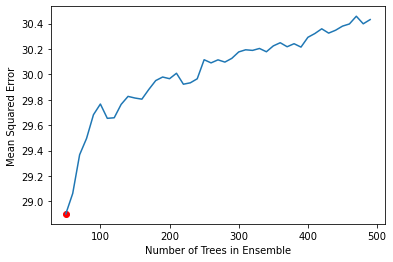

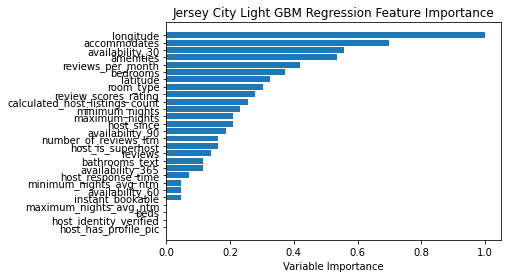

In [327]:
JC_preprocessed = preprocess(JC)
JC_preprocessed = remove_outliers(JC_preprocessed)

variables = JC_preprocessed.iloc[:, 1:].drop('price', axis=1)
target = JC_preprocessed[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

mse0os = []
ExplainedVariance = []

rand_st = 1

nTreeList = range(50, 500, 10)

for iTrees in nTreeList:
    depth = None

    hyper_params = {'boosting_type': 'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": iTrees}

    gbm = lgb.LGBMRegressor(**hyper_params, random_state=1)
    gbm.fit(data_train, target_train)

    prediction = gbm.predict(data_test)
    mse0os.append(mean_squared_error(target_test, prediction, squared=False))
    ExplainedVariance.append(explained_variance_score(target_test, prediction))

mse0os = np.array(mse0os)
min_arg = np.argmin(mse0os)
print("n_estimator which has minimum RMSE: ", nTreeList[min_arg], '\n')
print("least RMSE: ", mse0os[min_arg])
print("Explained Variance when n_estimator={}:".format(nTreeList[min_arg]), ExplainedVariance[min_arg])
 
plt.plot(nTreeList, mse0os)
plt.scatter(nTreeList[min_arg], mse0os[min_arg], color='red')
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('Mean Squared Error')
plt.show()
    
hyper_params = {'boosting_type': 'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": nTreeList[min_arg]}

gbm = lgb.LGBMRegressor(**hyper_params, random_state=1)
gbm.fit(data_train, target_train)

featureImportance = gbm.feature_importances_
 
featureImportance = featureImportance / featureImportance.max()
sorted_idx = numpy.argsort(featureImportance)
barPos = numpy.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, variable_names[sorted_idx])
plt.xlabel('Variable Importance')
plt.title('Jersey City Light GBM Regression Feature Importance')
plt.show()

In [243]:
# Hawaii

In [328]:
HI_preprocessed = preprocess(HI)
HI_preprocessed = remove_outliers(HI_preprocessed)

variables = HI_preprocessed.iloc[:, 1:].drop('price', axis=1)
target = HI_preprocessed[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 

rand_st = 1

start_ts=time.time()

hyper_params = {'boosting_type': 'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": 100}

gbm = lgb.LGBMRegressor(**hyper_params, random_state=1)

scores = cross_validate(estimator=gbm, X=data_np, y=target_np, scoring=scorers, cv=5)  

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       
scores_Expl_Var = scores['test_expl_var']
    
print("Hawaii Data")    
print('='*50)
print("Light GBM RMSE: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("Light GBM Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
print("CV Runtime:", time.time()-start_ts)
print('='*50)


Hawaii Data
Light GBM RMSE: 68.65 (+/- 2.41)
Light GBM Expl Var: 0.57 (+/- 0.05)
CV Runtime: 0.4462254047393799


n_estimator which has minimum RMSE:  490 

least RMSE:  63.25959441250972
Explained Variance when n_estimator=490: 0.643267700059602


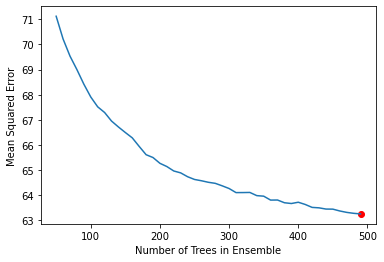

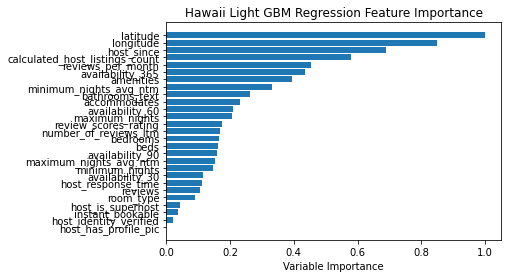

In [329]:
HI_preprocessed = preprocess(HI)
HI_preprocessed = remove_outliers(HI_preprocessed)

variables = HI_preprocessed.iloc[:, 1:].drop('price', axis=1)
target = HI_preprocessed[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

mse0os = []
ExplainedVariance = []

rand_st = 1

nTreeList = range(50, 500, 10)

for iTrees in nTreeList:
    depth = None

    hyper_params = {'boosting_type': 'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": iTrees}

    gbm = lgb.LGBMRegressor(**hyper_params, random_state=1)
    gbm.fit(data_train, target_train)

    prediction = gbm.predict(data_test)
    mse0os.append(mean_squared_error(target_test, prediction, squared=False))
    ExplainedVariance.append(explained_variance_score(target_test, prediction))

mse0os = np.array(mse0os)
min_arg = np.argmin(mse0os)
print("n_estimator which has minimum RMSE: ", nTreeList[min_arg], '\n')
print("least RMSE: ", mse0os[min_arg])
print("Explained Variance when n_estimator={}:".format(nTreeList[min_arg]), ExplainedVariance[min_arg])
 
plt.plot(nTreeList, mse0os)
plt.scatter(nTreeList[min_arg], mse0os[min_arg], color='red')
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('Mean Squared Error')
plt.show()
    
hyper_params = {'boosting_type': 'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": nTreeList[min_arg]}

gbm = lgb.LGBMRegressor(**hyper_params, random_state=1)
gbm.fit(data_train, target_train)

featureImportance = gbm.feature_importances_

featureImportance = featureImportance / featureImportance.max()
sorted_idx = numpy.argsort(featureImportance)
barPos = numpy.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, variable_names[sorted_idx])
plt.xlabel('Variable Importance')
plt.title('Hawaii Light GBM Regression Feature Importance')
plt.show()

In [245]:
# Santa Clara County

In [330]:
SCC_preprocessed = preprocess(SCC)
SCC_preprocessed = remove_outliers(SCC_preprocessed)

variables = SCC_preprocessed.iloc[:, 1:].drop('price', axis=1)
target = SCC_preprocessed[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 

rand_st = 1

start_ts=time.time()

hyper_params = {'boosting_type': 'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": 100}

gbm = lgb.LGBMRegressor(**hyper_params, random_state=1)

scores = cross_validate(estimator=gbm, X=data_np, y=target_np, scoring=scorers, cv=5)  

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       
scores_Expl_Var = scores['test_expl_var']
    
print("Santa Clara County Data")    
print('='*50)
print("Light GBM RMSE: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("Light GBM Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
print("CV Runtime:", time.time()-start_ts)
print('='*50)


Santa Clara County Data
Light GBM RMSE: 34.84 (+/- 3.70)
Light GBM Expl Var: 0.74 (+/- 0.07)
CV Runtime: 0.263638973236084


n_estimator which has minimum RMSE:  460 

least RMSE:  33.0504497756943
Explained Variance when n_estimator=460: 0.7545936178563488


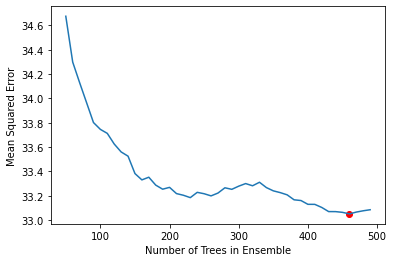

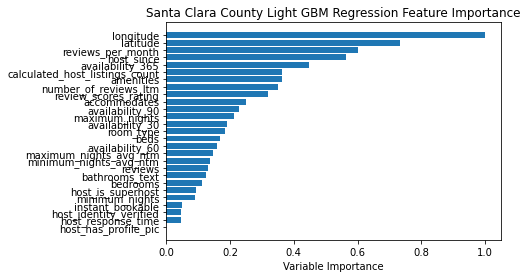

In [331]:
SCC_preprocessed = preprocess(SCC)
SCC_preprocessed = remove_outliers(SCC_preprocessed)

variables = SCC_preprocessed.iloc[:, 1:].drop('price', axis=1)
target = SCC_preprocessed[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

mse0os = []
ExplainedVariance = []

rand_st = 1

nTreeList = range(50, 500, 10)

for iTrees in nTreeList:
    depth = None
    
    hyper_params = {'boosting_type': 'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": iTrees}

    gbm = lgb.LGBMRegressor(**hyper_params, random_state=1)
    gbm.fit(data_train, target_train)

    prediction = gbm.predict(data_test)
    mse0os.append(mean_squared_error(target_test, prediction, squared=False))
    ExplainedVariance.append(explained_variance_score(target_test, prediction))

mse0os = np.array(mse0os)
min_arg = np.argmin(mse0os)
print("n_estimator which has minimum RMSE: ", nTreeList[min_arg], '\n')
print("least RMSE: ", mse0os[min_arg])
print("Explained Variance when n_estimator={}:".format(nTreeList[min_arg]), ExplainedVariance[min_arg])
 

plt.plot(nTreeList, mse0os)
plt.scatter(nTreeList[min_arg], mse0os[min_arg], color='red')
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('Mean Squared Error')
plt.show()
    
hyper_params = {'boosting_type': 'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": nTreeList[min_arg]}

gbm = lgb.LGBMRegressor(**hyper_params, random_state=1)
gbm.fit(data_train, target_train)

featureImportance = gbm.feature_importances_
 
featureImportance = featureImportance / featureImportance.max()
sorted_idx = numpy.argsort(featureImportance)
barPos = numpy.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, variable_names[sorted_idx])
plt.xlabel('Variable Importance')
plt.title('Santa Clara County Light GBM Regression Feature Importance')
plt.show()

In [247]:
# Clark County

In [332]:
CC_preprocessed = preprocess(CC)
CC_preprocessed = remove_outliers(CC_preprocessed)

variables = CC_preprocessed.iloc[:, 1:].drop('price', axis=1)
target = CC_preprocessed[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 

rand_st = 1

start_ts=time.time()

hyper_params = {'boosting_type': 'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": 100}

gbm = lgb.LGBMRegressor(**hyper_params, random_state=1)

scores = cross_validate(estimator=gbm, X=data_np, y=target_np, scoring=scorers, cv=5)  

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       
scores_Expl_Var = scores['test_expl_var']
    
print("Clark County")    
print('='*50)
print("Light GBM RMSE: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("Light GBM Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
print("CV Runtime:", time.time()-start_ts)
print('='*50)


Clark County
Light GBM RMSE: 56.53 (+/- 5.42)
Light GBM Expl Var: 0.67 (+/- 0.05)
CV Runtime: 0.3184647560119629


n_estimator which has minimum RMSE:  420 

least RMSE:  53.095525972960125
Explained Variance when n_estimator=420: 0.7013979499454748


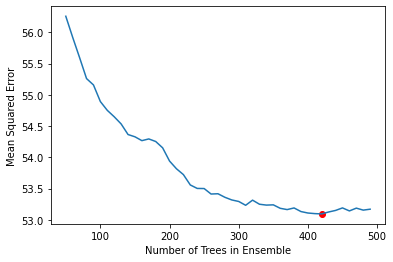

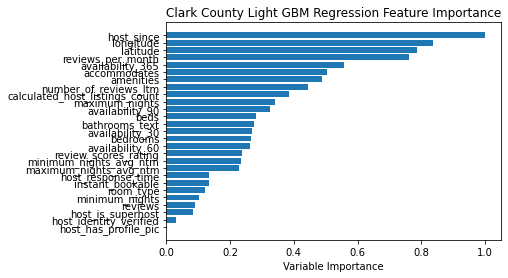

In [333]:
CC_preprocessed = preprocess(CC)
CC_preprocessed = remove_outliers(CC_preprocessed)

variables = CC_preprocessed.iloc[:, 1:].drop('price', axis=1)
target = CC_preprocessed[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

mse0os = []
ExplainedVariance = []

rand_st = 1

nTreeList = range(50, 500, 10)

for iTrees in nTreeList:
    depth = None

    hyper_params = {'boosting_type': 'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": iTrees}

    gbm = lgb.LGBMRegressor(**hyper_params, random_state=1)
    gbm.fit(data_train, target_train)

    prediction = gbm.predict(data_test)
    mse0os.append(mean_squared_error(target_test, prediction, squared=False))
    ExplainedVariance.append(explained_variance_score(target_test, prediction))

mse0os = np.array(mse0os)
min_arg = np.argmin(mse0os)
print("n_estimator which has minimum RMSE: ", nTreeList[min_arg], '\n')
print("least RMSE: ", mse0os[min_arg])
print("Explained Variance when n_estimator={}:".format(nTreeList[min_arg]), ExplainedVariance[min_arg])
 
plt.plot(nTreeList, mse0os)
plt.scatter(nTreeList[min_arg], mse0os[min_arg], color='red')
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('Mean Squared Error')
plt.show()
    
hyper_params = {'boosting_type': 'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": nTreeList[min_arg]}

gbm = lgb.LGBMRegressor(**hyper_params, random_state=1)
gbm.fit(data_train, target_train)

featureImportance = gbm.feature_importances_
 
featureImportance = featureImportance / featureImportance.max()
sorted_idx = numpy.argsort(featureImportance)
barPos = numpy.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, variable_names[sorted_idx])
plt.xlabel('Variable Importance')
plt.title('Clark County Light GBM Regression Feature Importance')
plt.show()

### Classification

In [ ]:
# New York

In [334]:
NY_preprocessed_c = to_category(NY_preprocessed)

variables = NY_preprocessed_c.iloc[:, 1:].drop('price', axis=1)
target = NY_preprocessed_c[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 

rand_st = 1

start_ts=time.time()

hyper_params = {'boosting_type':'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": 100}

gbm = lgb.LGBMClassifier(**hyper_params, random_state=rand_st)

scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}

scores = cross_validate(estimator=gbm, X=data_np, y=target_np, scoring = scorers, cv=5)

scores_Acc = scores['test_Accuracy']        

print("NewYork Data")
print('='*50)
print("Light GBM Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    

scores_AUC = scores['test_roc_auc']                                                                           

print("Light GBM AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
print("CV Runtime:", time.time()-start_ts)
print('='*50)


NewYork Data
Light GBM Acc: 0.85 (+/- 0.01)
Light GBM AUC: 0.93 (+/- 0.01)
CV Runtime: 1.204850673675537


n_estimator which has maximum ACC:  410 

Maximum ACC:  0.8527178864257516
AUC when n_estimator=410: 0.852732813310384


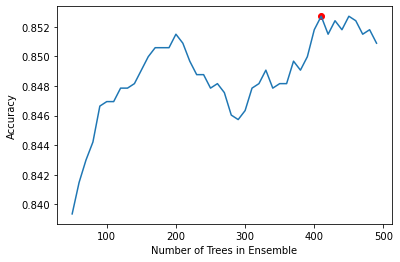

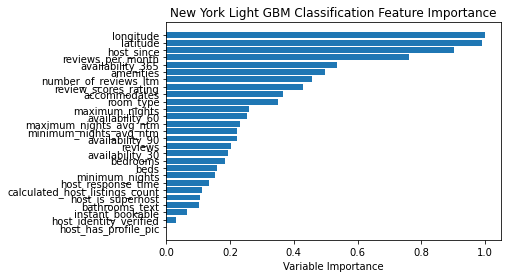

In [335]:
NY_preprocessed_c = to_category(NY_preprocessed)

variables = NY_preprocessed_c.iloc[:, 1:].drop('price', axis=1)
target = NY_preprocessed_c[['price']]

variable_names = variables.columns

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

ACC = []
AUC = []

rand_st = 1

nTreeList = range(50, 500, 10)

for iTrees in nTreeList:
    depth = None

    hyper_params = {'boosting_type':'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": iTrees}
    gbm = lgb.LGBMClassifier(**hyper_params, random_state=rand_st)
    
    gbm.fit(data_train, target_train)

    prediction = gbm.predict(data_test)
    ACC.append(accuracy_score(target_test, prediction))
    AUC.append(roc_auc_score(target_test, prediction))

ACC = np.array(ACC)
max_arg = np.argmax(ACC)
print("n_estimator which has maximum ACC: ", nTreeList[max_arg], '\n')
print("Maximum ACC: ", ACC[max_arg])
print("AUC when n_estimator={}:".format(nTreeList[max_arg]), AUC[max_arg])
 
plt.plot(nTreeList, ACC)
plt.scatter(nTreeList[max_arg], ACC[max_arg], color='red')
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('Accuracy')
plt.show()

hyper_params = {'boosting_type':'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": iTrees}
gbm = lgb.LGBMClassifier(**hyper_params, random_state=rand_st)

gbm.fit(data_train, target_train)

featureImportance = gbm.feature_importances_
 
featureImportance = featureImportance / featureImportance.max()
sorted_idx = numpy.argsort(featureImportance)
barPos = numpy.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, variable_names[sorted_idx])
plt.xlabel('Variable Importance')
plt.title('New York Light GBM Classification Feature Importance')
plt.show()

In [272]:
# San Francisco

In [336]:
SF_preprocessed_c = to_category(SF_preprocessed)

variables = SF_preprocessed_c.iloc[:, 1:].drop('price', axis=1)
target = SF_preprocessed_c[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 

rand_st = 1

start_ts=time.time()

hyper_params = {'boosting_type':'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": 100}

gbm = lgb.LGBMClassifier(**hyper_params, random_state=rand_st)

scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}

scores = cross_validate(estimator=gbm, X=data_np, y=target_np, scoring = scorers, cv=5)

scores_Acc = scores['test_Accuracy']        

print("San Francisco Data")
print('='*50)
print("Light GBM Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    

scores_AUC = scores['test_roc_auc']                                                                    

print("Light GBM AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
print("CV Runtime:", time.time()-start_ts)
print('='*50)


San Francisco Data
Light GBM Acc: 0.79 (+/- 0.05)
Light GBM AUC: 0.88 (+/- 0.03)
CV Runtime: 0.32444047927856445


n_estimator which has maximum ACC:  110 

Maximum ACC:  0.8072289156626506
AUC when n_estimator=110: 0.8071740544559057


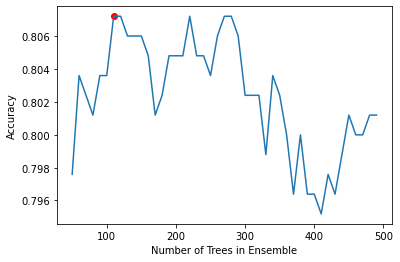

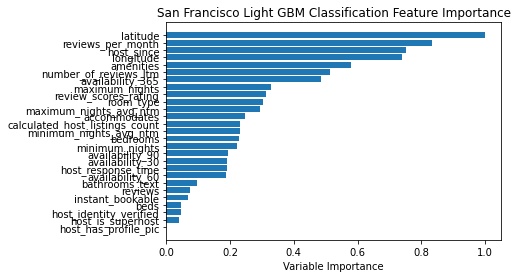

In [337]:
SF_preprocessed_c = to_category(SF_preprocessed)

variables = SF_preprocessed_c.iloc[:, 1:].drop('price', axis=1)
target = SF_preprocessed_c[['price']]

variable_names = variables.columns

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

ACC = []
AUC = []

rand_st = 1

nTreeList = range(50, 500, 10)

for iTrees in nTreeList:
    depth = None

    hyper_params = {'boosting_type':'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": iTrees}
    gbm = lgb.LGBMClassifier(**hyper_params, random_state=rand_st)
    
    gbm.fit(data_train, target_train)

    prediction = gbm.predict(data_test)
    ACC.append(accuracy_score(target_test, prediction))
    AUC.append(roc_auc_score(target_test, prediction))

ACC = np.array(ACC)
max_arg = np.argmax(ACC)
print("n_estimator which has maximum ACC: ", nTreeList[max_arg], '\n')
print("Maximum ACC: ", ACC[max_arg])
print("AUC when n_estimator={}:".format(nTreeList[max_arg]), AUC[max_arg])
 
plt.plot(nTreeList, ACC)
plt.scatter(nTreeList[max_arg], ACC[max_arg], color='red')
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('Accuracy')
#plot.ylim([0.0, 1.1*max(mseOob)])
plt.show()

hyper_params = {'boosting_type':'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": iTrees}
gbm = lgb.LGBMClassifier(**hyper_params, random_state=rand_st)

gbm.fit(data_train, target_train)

featureImportance = gbm.feature_importances_
 
featureImportance = featureImportance / featureImportance.max()
sorted_idx = numpy.argsort(featureImportance)
barPos = numpy.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, variable_names[sorted_idx])
plt.xlabel('Variable Importance')
plt.title('San Francisco Light GBM Classification Feature Importance')
plt.show()

In [275]:
# Jersey City

In [338]:
JC_preprocessed_c = to_category(JC_preprocessed)

variables = JC_preprocessed_c.iloc[:, 1:].drop('price', axis=1)
target = JC_preprocessed_c[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 

rand_st = 1

start_ts=time.time()

hyper_params = {'boosting_type':'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": 100}

gbm = lgb.LGBMClassifier(**hyper_params, random_state=rand_st)

scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}

scores = cross_validate(estimator=gbm, X=data_np, y=target_np, scoring = scorers, cv=5)

scores_Acc = scores['test_Accuracy']        

print("Jersey City")
print('='*50)
print("Light GBM Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    

scores_AUC = scores['test_roc_auc']                                                                     

print("Light GBM AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
print("CV Runtime:", time.time()-start_ts)
print('='*50)


Jersey City
Light GBM Acc: 0.86 (+/- 0.09)
Light GBM AUC: 0.95 (+/- 0.05)
CV Runtime: 0.19196200370788574


n_estimator which has maximum ACC:  80 

Maximum ACC:  0.8790697674418605
AUC when n_estimator=80: 0.8796953436039467


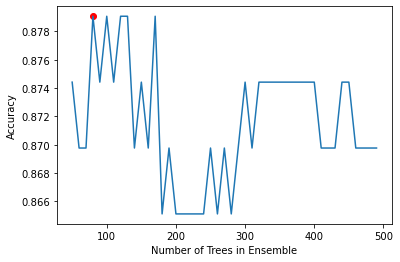

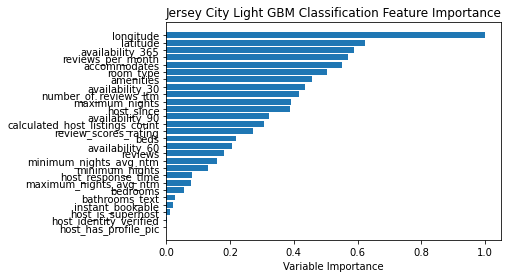

In [339]:
JC_preprocessed_c = to_category(JC_preprocessed)

variables = JC_preprocessed_c.iloc[:, 1:].drop('price', axis=1)
target = JC_preprocessed_c[['price']]

variable_names = variables.columns

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

ACC = []
AUC = []

rand_st = 1

nTreeList = range(50, 500, 10)

for iTrees in nTreeList:
    depth = None

    hyper_params = {'boosting_type':'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": iTrees}
    gbm = lgb.LGBMClassifier(**hyper_params, random_state=rand_st)
    
    gbm.fit(data_train, target_train)

    prediction = gbm.predict(data_test)
    ACC.append(accuracy_score(target_test, prediction))
    AUC.append(roc_auc_score(target_test, prediction))

ACC = np.array(ACC)
max_arg = np.argmax(ACC)
print("n_estimator which has maximum ACC: ", nTreeList[max_arg], '\n')
print("Maximum ACC: ", ACC[max_arg])
print("AUC when n_estimator={}:".format(nTreeList[max_arg]), AUC[max_arg])
 
plt.plot(nTreeList, ACC)
plt.scatter(nTreeList[max_arg], ACC[max_arg], color='red')
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('Accuracy')
plt.show()

hyper_params = {'boosting_type':'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": iTrees}
gbm = lgb.LGBMClassifier(**hyper_params, random_state=rand_st)

gbm.fit(data_train, target_train)

featureImportance = gbm.feature_importances_
 
featureImportance = featureImportance / featureImportance.max()
sorted_idx = numpy.argsort(featureImportance)
barPos = numpy.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, variable_names[sorted_idx])
plt.xlabel('Variable Importance')
plt.title('Jersey City Light GBM Classification Feature Importance')
plt.show()

In [278]:
# Hawaii

In [340]:
HI_preprocessed_c = to_category(HI_preprocessed)

variables = HI_preprocessed_c.iloc[:, 1:].drop('price', axis=1)
target = HI_preprocessed_c[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 

rand_st = 1

start_ts=time.time()

hyper_params = {'boosting_type':'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": 100}

gbm = lgb.LGBMClassifier(**hyper_params, random_state=rand_st)

scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}

scores = cross_validate(estimator=gbm, X=data_np, y=target_np, scoring = scorers, cv=5)

scores_Acc = scores['test_Accuracy']        

print("Hawaii Data")
print('='*50)
print("Light GBM Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    

scores_AUC = scores['test_roc_auc']                                                                     

print("Light GBM AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
print("CV Runtime:", time.time()-start_ts)
print('='*50)


Hawaii Data
Light GBM Acc: 0.80 (+/- 0.02)
Light GBM AUC: 0.89 (+/- 0.03)
CV Runtime: 0.5900261402130127


n_estimator which has maximum ACC:  400 

Maximum ACC:  0.8272154245457917
AUC when n_estimator=400: 0.8274227647821045


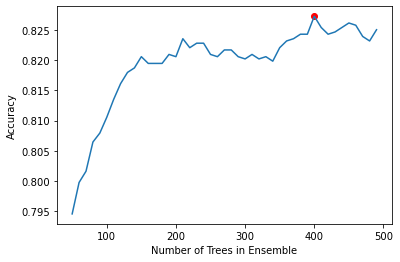

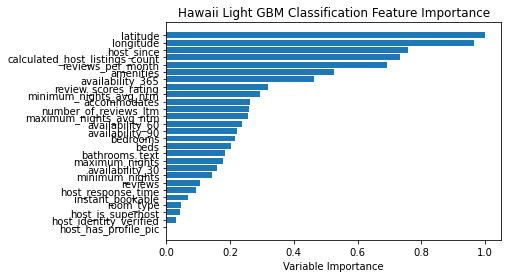

In [341]:
HI_preprocessed_c = to_category(HI_preprocessed)

variables = HI_preprocessed_c.iloc[:, 1:].drop('price', axis=1)
target = HI_preprocessed_c[['price']]

variable_names = variables.columns

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

ACC = []
AUC = []

rand_st = 1

nTreeList = range(50, 500, 10)

for iTrees in nTreeList:
    depth = None

    hyper_params = {'boosting_type':'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": iTrees}
    gbm = lgb.LGBMClassifier(**hyper_params, random_state=rand_st)
    
    gbm.fit(data_train, target_train)

    prediction = gbm.predict(data_test)
    ACC.append(accuracy_score(target_test, prediction))
    AUC.append(roc_auc_score(target_test, prediction))

ACC = np.array(ACC)
max_arg = np.argmax(ACC)
print("n_estimator which has maximum ACC: ", nTreeList[max_arg], '\n')
print("Maximum ACC: ", ACC[max_arg])
print("AUC when n_estimator={}:".format(nTreeList[max_arg]), AUC[max_arg])
 
plt.plot(nTreeList, ACC)
plt.scatter(nTreeList[max_arg], ACC[max_arg], color='red')
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('Accuracy')
plt.show()

hyper_params = {'boosting_type':'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": iTrees}
gbm = lgb.LGBMClassifier(**hyper_params, random_state=rand_st)

gbm.fit(data_train, target_train)

featureImportance = gbm.feature_importances_
 
featureImportance = featureImportance / featureImportance.max()
sorted_idx = numpy.argsort(featureImportance)
barPos = numpy.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, variable_names[sorted_idx])
plt.xlabel('Variable Importance')
plt.title('Hawaii Light GBM Classification Feature Importance')
plt.show()

In [281]:
# Santa Clara County

In [342]:
SCC_preprocessed_c = to_category(SCC_preprocessed)

variables = SCC_preprocessed_c.iloc[:, 1:].drop('price', axis=1)
target = SCC_preprocessed_c[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 

rand_st = 1

start_ts=time.time()

hyper_params = {'boosting_type':'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": 100}

gbm = lgb.LGBMClassifier(**hyper_params, random_state=rand_st)

scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}

scores = cross_validate(estimator=gbm, X=data_np, y=target_np, scoring = scorers, cv=5)

scores_Acc = scores['test_Accuracy']        

print("Santa Clara County")
print('='*50)
print("Light GBM Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    

scores_AUC = scores['test_roc_auc']                                                                     

print("Light GBM AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
print("CV Runtime:", time.time()-start_ts)
print('='*50)


Santa Clara County
Light GBM Acc: 0.88 (+/- 0.06)
Light GBM AUC: 0.94 (+/- 0.04)
CV Runtime: 0.3633840084075928


n_estimator which has maximum ACC:  480 

Maximum ACC:  0.8949704142011834
AUC when n_estimator=480: 0.8950277935834027


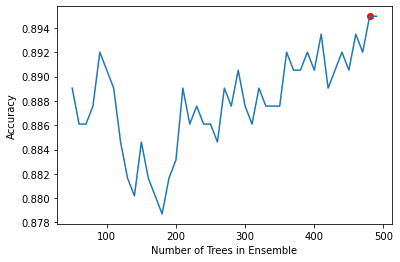

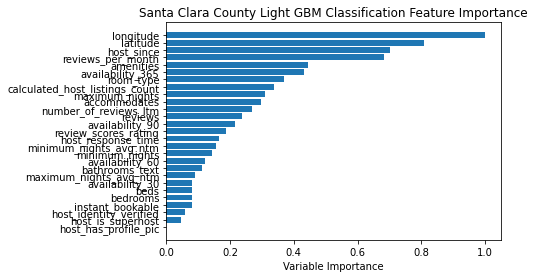

In [343]:
SCC_preprocessed_c = to_category(SCC_preprocessed)

variables = SCC_preprocessed_c.iloc[:, 1:].drop('price', axis=1)
target = SCC_preprocessed_c[['price']]

variable_names = variables.columns

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

ACC = []
AUC = []

rand_st = 1

nTreeList = range(50, 500, 10)

for iTrees in nTreeList:
    depth = None

    hyper_params = {'boosting_type':'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": iTrees}
    gbm = lgb.LGBMClassifier(**hyper_params, random_state=rand_st)
    
    gbm.fit(data_train, target_train)

    prediction = gbm.predict(data_test)
    ACC.append(accuracy_score(target_test, prediction))
    AUC.append(roc_auc_score(target_test, prediction))

ACC = np.array(ACC)
max_arg = np.argmax(ACC)
print("n_estimator which has maximum ACC: ", nTreeList[max_arg], '\n')
print("Maximum ACC: ", ACC[max_arg])
print("AUC when n_estimator={}:".format(nTreeList[max_arg]), AUC[max_arg])
 
plt.plot(nTreeList, ACC)
plt.scatter(nTreeList[max_arg], ACC[max_arg], color='red')
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('Accuracy')
plt.show()

hyper_params = {'boosting_type':'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": iTrees}
gbm = lgb.LGBMClassifier(**hyper_params, random_state=rand_st)

gbm.fit(data_train, target_train)

featureImportance = gbm.feature_importances_
 
featureImportance = featureImportance / featureImportance.max()
sorted_idx = numpy.argsort(featureImportance)
barPos = numpy.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, variable_names[sorted_idx])
plt.xlabel('Variable Importance')
plt.title('Santa Clara County Light GBM Classification Feature Importance')
plt.show()

In [287]:
# Clark County

In [344]:
CC_preprocessed_c = to_category(CC_preprocessed)

variables = CC_preprocessed_c.iloc[:, 1:].drop('price', axis=1)
target = CC_preprocessed_c[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 

rand_st = 1

start_ts=time.time()

hyper_params = {'boosting_type':'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": 100}

gbm = lgb.LGBMClassifier(**hyper_params, random_state=rand_st)

scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}

scores = cross_validate(estimator=gbm, X=data_np, y=target_np, scoring = scorers, cv=5)

scores_Acc = scores['test_Accuracy']        

print("Clark County")
print('='*50)
print("Light GBM Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    

scores_AUC = scores['test_roc_auc']                                                                     

print("Light GBM AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
print("CV Runtime:", time.time()-start_ts)
print('='*50)


Clark County
Light GBM Acc: 0.86 (+/- 0.05)
Light GBM AUC: 0.94 (+/- 0.02)
CV Runtime: 0.3427619934082031


n_estimator which has maximum ACC:  220 

Maximum ACC:  0.8882042253521126
AUC when n_estimator=220: 0.8882197938463924


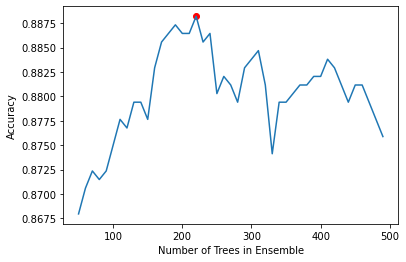

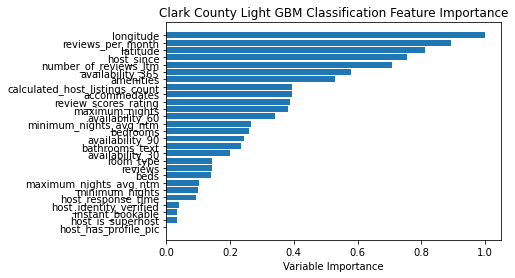

In [345]:
CC_preprocessed_c = to_category(CC_preprocessed)

variables = CC_preprocessed_c.iloc[:, 1:].drop('price', axis=1)
target = CC_preprocessed_c[['price']]

variable_names = variables.columns

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

ACC = []
AUC = []

rand_st = 1

nTreeList = range(50, 500, 10)

for iTrees in nTreeList:
    depth = None

    hyper_params = {'boosting_type':'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": iTrees}
    gbm = lgb.LGBMClassifier(**hyper_params, random_state=rand_st)
    
    gbm.fit(data_train, target_train)

    prediction = gbm.predict(data_test)
    ACC.append(accuracy_score(target_test, prediction))
    AUC.append(roc_auc_score(target_test, prediction))

ACC = np.array(ACC)
max_arg = np.argmax(ACC)
print("n_estimator which has maximum ACC: ", nTreeList[max_arg], '\n')
print("Maximum ACC: ", ACC[max_arg])
print("AUC when n_estimator={}:".format(nTreeList[max_arg]), AUC[max_arg])
 
plt.plot(nTreeList, ACC)
plt.scatter(nTreeList[max_arg], ACC[max_arg], color='red')
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('Accuracy')
plt.show()

hyper_params = {'boosting_type':'gbdt', 'learning_rate': 0.1, "max_depth": 3, "n_estimators": iTrees}
gbm = lgb.LGBMClassifier(**hyper_params, random_state=rand_st)

gbm.fit(data_train, target_train)

featureImportance = gbm.feature_importances_
 
featureImportance = featureImportance / featureImportance.max()
sorted_idx = numpy.argsort(featureImportance)
barPos = numpy.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, variable_names[sorted_idx])
plt.xlabel('Variable Importance')
plt.title('Clark County Light GBM Classification Feature Importance')
plt.show()

## 3. Neural Network

### Regression

In [ ]:
# New York

In [346]:
variables = NY_preprocessed.iloc[:, 1:].drop('price', axis=1)
target = NY_preprocessed[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 
    
rand_st = 1

start_ts=time.time()
rgr=MLPRegressor(activation='logistic', solver='lbfgs', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(10,), random_state=rand_st)
scores=cross_validate(estimator=rgr, X=data_np, y=target_np, scoring=scorers, cv=5)                                                                                                  

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       #Turns negative MSE scores into RMSE
scores_Expl_Var = scores['test_expl_var']

print("NewYork Data")
print('='*50)
print("Neural Network RMSE:: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("Neural Network Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
print("CV Runtime:", time.time()-start_ts)
print('='*50)

NewYork Data
Neural Network RMSE:: 0.79 (+/- 0.21)
Neural Network Expl Var: 0.37 (+/- 0.36)
CV Runtime: 43.52082920074463


In [58]:
# San Francisco

In [347]:
variables = SF_preprocessed.iloc[:, 1:].drop('price', axis=1)
target = SF_preprocessed[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 
    
rand_st = 1

start_ts=time.time()
rgr=MLPRegressor(activation='logistic', solver='lbfgs', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(10,), random_state=rand_st)
scores=cross_validate(estimator=rgr, X=data_np, y=target_np, scoring=scorers, cv=5)                                                                                                  

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       #Turns negative MSE scores into RMSE
scores_Expl_Var = scores['test_expl_var']

print("San Francisco Data")
print('='*50)
print("Neural Network RMSE:: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("Neural Network Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
print("CV Runtime:", time.time()-start_ts)
print('='*50)

San Francisco Data
Neural Network RMSE:: 0.98 (+/- 0.14)
Neural Network Expl Var: 0.04 (+/- 0.26)
CV Runtime: 14.650042057037354


In [60]:
# Jersey City

In [348]:
variables = JC_preprocessed.iloc[:, 1:].drop('price', axis=1)
target = JC_preprocessed[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 
    
rand_st = 1

start_ts=time.time()
rgr=MLPRegressor(activation='logistic', solver='lbfgs', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(10,), random_state=rand_st)
scores=cross_validate(estimator=rgr, X=data_np, y=target_np, scoring=scorers, cv=5)                                                                                                  

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       #Turns negative MSE scores into RMSE
scores_Expl_Var = scores['test_expl_var']

print("Jersey City Data")
print('='*50)
print("Neural Network RMSE:: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("Neural Network Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
print("CV Runtime:", time.time()-start_ts)
print('='*50)

Jersey City Data
Neural Network RMSE:: 0.97 (+/- 0.18)
Neural Network Expl Var: 0.05 (+/- 0.34)
CV Runtime: 3.363999128341675


In [62]:
# Hawaii

In [349]:
variables = HI_preprocessed.iloc[:, 1:].drop('price', axis=1)
target = HI_preprocessed[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 
    
rand_st = 1

start_ts=time.time()
rgr=MLPRegressor(activation='logistic', solver='lbfgs', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(10,), random_state=rand_st)
scores=cross_validate(estimator=rgr, X=data_np, y=target_np, scoring=scorers, cv=5)                                                                                                  

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       #Turns negative MSE scores into RMSE
scores_Expl_Var = scores['test_expl_var']

print("Hawaii Data")
print('='*50)
print("Neural Network RMSE:: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("Neural Network Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
print("CV Runtime:", time.time()-start_ts)
print('='*50)

Hawaii Data
Neural Network RMSE:: 0.98 (+/- 0.07)
Neural Network Expl Var: 0.03 (+/- 0.14)
CV Runtime: 31.40847682952881


In [64]:
# Santa Clara County

In [350]:
variables = SCC_preprocessed.iloc[:, 1:].drop('price', axis=1)
target = SCC_preprocessed[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 
    
rand_st = 1

start_ts=time.time()
rgr=MLPRegressor(activation='logistic', solver='lbfgs', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(10,), random_state=rand_st)
scores=cross_validate(estimator=rgr, X=data_np, y=target_np, scoring=scorers, cv=5)                                                                                                  

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       #Turns negative MSE scores into RMSE
scores_Expl_Var = scores['test_expl_var']

print("Santa Clara County Data")
print('='*50)
print("Neural Network RMSE:: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("Neural Network Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
print("CV Runtime:", time.time()-start_ts)
print('='*50)

Santa Clara County Data
Neural Network RMSE:: 1.00 (+/- 0.02)
Neural Network Expl Var: -0.00 (+/- 0.03)
CV Runtime: 4.526338338851929


In [66]:
# Clark County

In [351]:
variables = CC_preprocessed.iloc[:, 1:].drop('price', axis=1)
target = CC_preprocessed[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 
    
rand_st = 1

start_ts=time.time()
rgr=MLPRegressor(activation='logistic', solver='lbfgs', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(10,), random_state=rand_st)
scores=cross_validate(estimator=rgr, X=data_np, y=target_np, scoring=scorers, cv=5)                                                                                                  

scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       #Turns negative MSE scores into RMSE
scores_Expl_Var = scores['test_expl_var']

print("Clark County Data")
print('='*50)
print("Neural Network RMSE:: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
print("Neural Network Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
print("CV Runtime:", time.time()-start_ts)
print('='*50)

Clark County Data
Neural Network RMSE:: 0.78 (+/- 0.16)
Neural Network Expl Var: 0.37 (+/- 0.24)
CV Runtime: 21.618338346481323


### Classification

In [186]:
# New York

In [352]:
NY_preprocessed_c = to_category(NY_preprocessed)

variables = NY_preprocessed_c.iloc[:, 1:].drop('price', axis=1)
target = NY_preprocessed_c[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 
    
rand_st = 1

start_ts=time.time()
clf = MLPClassifier(activation='logistic', solver='adam', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(10,), random_state=rand_st) 


scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}

scores = cross_validate(estimator=clf, X=data_np, y=target_np, scoring = scorers, cv=5)

scores_Acc = scores['test_Accuracy']        

print("NewYork Data")
print('='*50)
print("Neural Network Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    

scores_AUC = scores['test_roc_auc']                                                                     #Only works with binary classes, not multiclass                  

print("Neural Network AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
print("CV Runtime:", time.time()-start_ts)
print('='*50)

NewYork Data
Neural Network Acc: 0.83 (+/- 0.01)
Neural Network AUC: 0.88 (+/- 0.01)
CV Runtime: 15.767682790756226


In [ ]:
# San Francisco

In [353]:
SF_preprocessed_c = to_category(SF_preprocessed)

variables = SF_preprocessed_c.iloc[:, 1:].drop('price', axis=1)
target = SF_preprocessed_c[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 
    
rand_st = 1

start_ts=time.time()
clf = MLPClassifier(activation='logistic', solver='adam', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(10,), random_state=rand_st) 


scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}

scores = cross_validate(estimator=clf, X=data_np, y=target_np, scoring = scorers, cv=5)

scores_Acc = scores['test_Accuracy']        

print("San Francisco Data")
print('='*50)
print("Neural Network Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    

scores_AUC = scores['test_roc_auc']                                                                     #Only works with binary classes, not multiclass                  

print("Neural Network AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
print("CV Runtime:", time.time()-start_ts)
print('='*50)

San Francisco Data
Neural Network Acc: 0.65 (+/- 0.24)
Neural Network AUC: 0.69 (+/- 0.31)
CV Runtime: 6.843407392501831


In [ ]:
# Jersey City 

In [354]:
JC_preprocessed_c = to_category(JC_preprocessed)

variables = JC_preprocessed_c.iloc[:, 1:].drop('price', axis=1)
target = JC_preprocessed_c[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 
    
rand_st = 1

start_ts=time.time()
clf = MLPClassifier(activation='logistic', solver='adam', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(10,), random_state=rand_st) 


scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}

scores = cross_validate(estimator=clf, X=data_np, y=target_np, scoring = scorers, cv=5)

scores_Acc = scores['test_Accuracy']        

print("Jersey City Data")
print('='*50)
print("Neural Network Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    

scores_AUC = scores['test_roc_auc']                                                                     #Only works with binary classes, not multiclass                  

print("Neural Network AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
print("CV Runtime:", time.time()-start_ts)
print('='*50)

Jersey City Data
Neural Network Acc: 0.76 (+/- 0.32)
Neural Network AUC: 0.82 (+/- 0.38)
CV Runtime: 5.01814866065979


In [191]:
# Hawaii

In [355]:
HI_preprocessed_c = to_category(HI_preprocessed)

variables = HI_preprocessed_c.iloc[:, 1:].drop('price', axis=1)
target = HI_preprocessed_c[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 
    
rand_st = 1

start_ts=time.time()
clf = MLPClassifier(activation='logistic', solver='adam', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(10,), random_state=rand_st) 


scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}

scores = cross_validate(estimator=clf, X=data_np, y=target_np, scoring = scorers, cv=5)

scores_Acc = scores['test_Accuracy']        

print("Hawaii Data")
print('='*50)
print("Neural Network Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    

scores_AUC = scores['test_roc_auc']                                                                     #Only works with binary classes, not multiclass                  

print("Neural Network AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
print("CV Runtime:", time.time()-start_ts)
print('='*50)

Hawaii Data
Neural Network Acc: 0.71 (+/- 0.02)
Neural Network AUC: 0.79 (+/- 0.01)
CV Runtime: 16.41882300376892


In [193]:
# Santa Clara City 

In [356]:
SCC_preprocessed_c = to_category(SCC_preprocessed)

variables = SCC_preprocessed_c.iloc[:, 1:].drop('price', axis=1)
target = SCC_preprocessed_c[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 
    
rand_st = 1

start_ts=time.time()
clf = MLPClassifier(activation='logistic', solver='adam', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(10,), random_state=rand_st) 


scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}

scores = cross_validate(estimator=clf, X=data_np, y=target_np, scoring = scorers, cv=5)

scores_Acc = scores['test_Accuracy']        

print("Santa Clara County Data")
print('='*50)
print("Neural Network Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    

scores_AUC = scores['test_roc_auc']                                                                     #Only works with binary classes, not multiclass                  

print("Neural Network AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
print("CV Runtime:", time.time()-start_ts)
print('='*50)

Santa Clara County Data
Neural Network Acc: 0.86 (+/- 0.06)
Neural Network AUC: 0.90 (+/- 0.07)
CV Runtime: 12.21334457397461


In [195]:
# Clark County

In [357]:
CC_preprocessed_c = to_category(CC_preprocessed)

variables = CC_preprocessed_c.iloc[:, 1:].drop('price', axis=1)
target = CC_preprocessed_c[['price']]

data_np=np.asarray(variables)
target_np=np.asarray(target)
target_np = target_np.reshape(len(target_np))

data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 
    
rand_st = 1

start_ts=time.time()
clf = MLPClassifier(activation='logistic', solver='adam', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(10,), random_state=rand_st) 


scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}

scores = cross_validate(estimator=clf, X=data_np, y=target_np, scoring = scorers, cv=5)

scores_Acc = scores['test_Accuracy']        

print("Clark County Data")
print('='*50)
print("Neural Network Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    

scores_AUC = scores['test_roc_auc']                                                                     #Only works with binary classes, not multiclass                  

print("Neural Network AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
print("CV Runtime:", time.time()-start_ts)
print('='*50)

Clark County Data
Neural Network Acc: 0.81 (+/- 0.02)
Neural Network AUC: 0.89 (+/- 0.02)
CV Runtime: 11.700060367584229
